# Classificador de Imagens

Classificador de imagens em escala de cinza, utilizando os algoritmos LBP e GLCM como extratores de características.


## Carregar as imagens

Carrega as imagens do dataset e as converte para escala de cinza

In [18]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import importlib
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('.env', override=True)


True

In [19]:
# Import the image segmentation tools
import tools.image_tools as it

importlib.reload(it)

from tools.image_tools import (
    segment_image_auto,
    segment_images_by_category_auto,
    calculate_dynamic_k, 
    visualize_image_segmentation_auto,
    merge_image_categories_dicts,
    load_train_images_dict
)


In [20]:
import warnings

# Suprime warnings do JobLib relacionados ao ResourceTracker
# Evita poluição do output com mensagens irrelevantes
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')
warnings.filterwarnings('ignore', message='.*resource_tracker.*')
warnings.filterwarnings('ignore', message='.*Cannot register.*')


dogs examples:


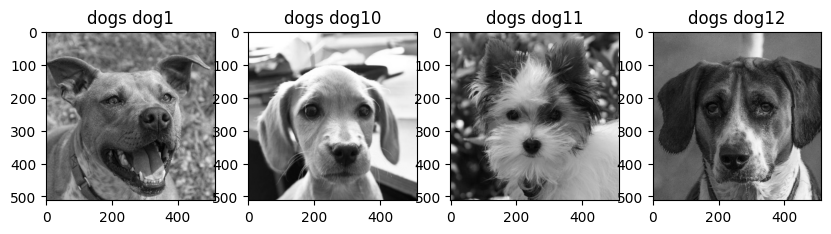

cats examples:


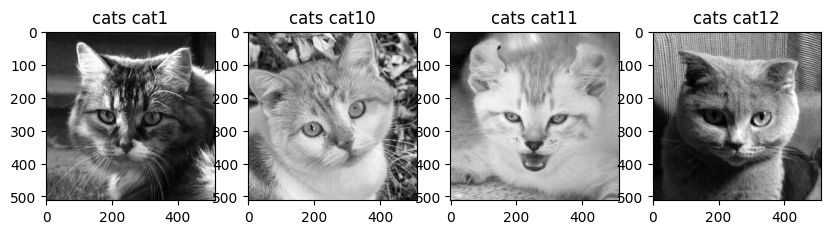

lions examples:


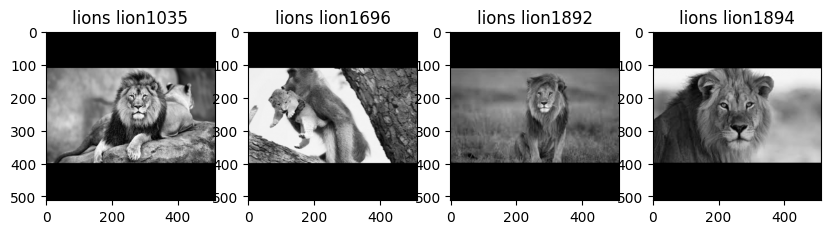

horses examples:


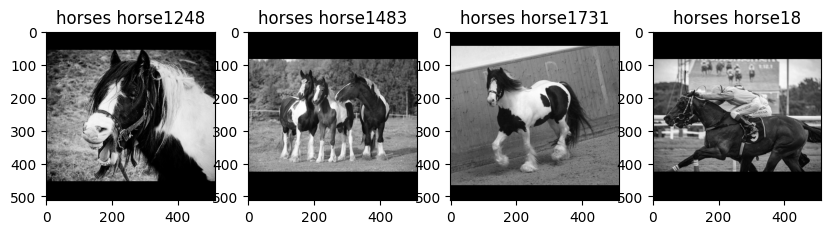

In [ ]:
from typing import Dict, List
import numpy as np

images_directory = "./images/pieces"
image_categories = ["dogs", "cats", "lions", "horses"]
n_examples = 4
NEEDS_RESIZE = int(os.getenv("NEEDS_RESIZE", True))
RESIZE_SIZE = int(os.getenv("RESIZE_SIZE", 512))
ACCEPTED_IMAGES_EXTENSIONS = (".jpg", ".jpeg", ".png")

train_images_by_categories = load_train_images_dict(
    images_directory,
    image_categories,
    ACCEPTED_IMAGES_EXTENSIONS,
    NEEDS_RESIZE,
)


def show_gray_scale_image_examples(
    images: Dict[str, np.ndarray], n: int = 3, label: str = "Example"
) -> None:
    """
    Display grayscale image examples from a dictionary of images.
    
    Args:
        images (Dict[str, np.ndarray]): Dictionary with filename as key and image array as value
        n (int): Number of images to display (default: 3)
        label (str): Label prefix for image titles (default: "Example")
    """
    # Convert dictionary items to list and take first n items
    items = list(images.items())[:n]
    plt.figure(figsize=(10, 10))
    for i, (key, img) in enumerate(items):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(f"{label} {key}")
        plt.axis("on")


def show_examples_by_category(
    categories: List[str], 
    images: Dict[str, Dict[str, np.ndarray]], 
    n: int = 3
) -> None:
    """
    Display image examples for each category.
    
    Args:
        categories (List[str]): List of category names
        images (Dict[str, Dict[str, np.ndarray]]): Nested dictionary structure:
                                                  {category: {filename: image_array}}
        n (int): Number of images per category to display (default: 3)
    """
    for category in categories:
        print(f"{category} examples:")
        show_gray_scale_image_examples(images[category], n=n, label=category)
        plt.show()


show_examples_by_category(image_categories, train_images_by_categories, n=n_examples)

Mostra o histograma das imagens de exemplo:

dogs histograms:


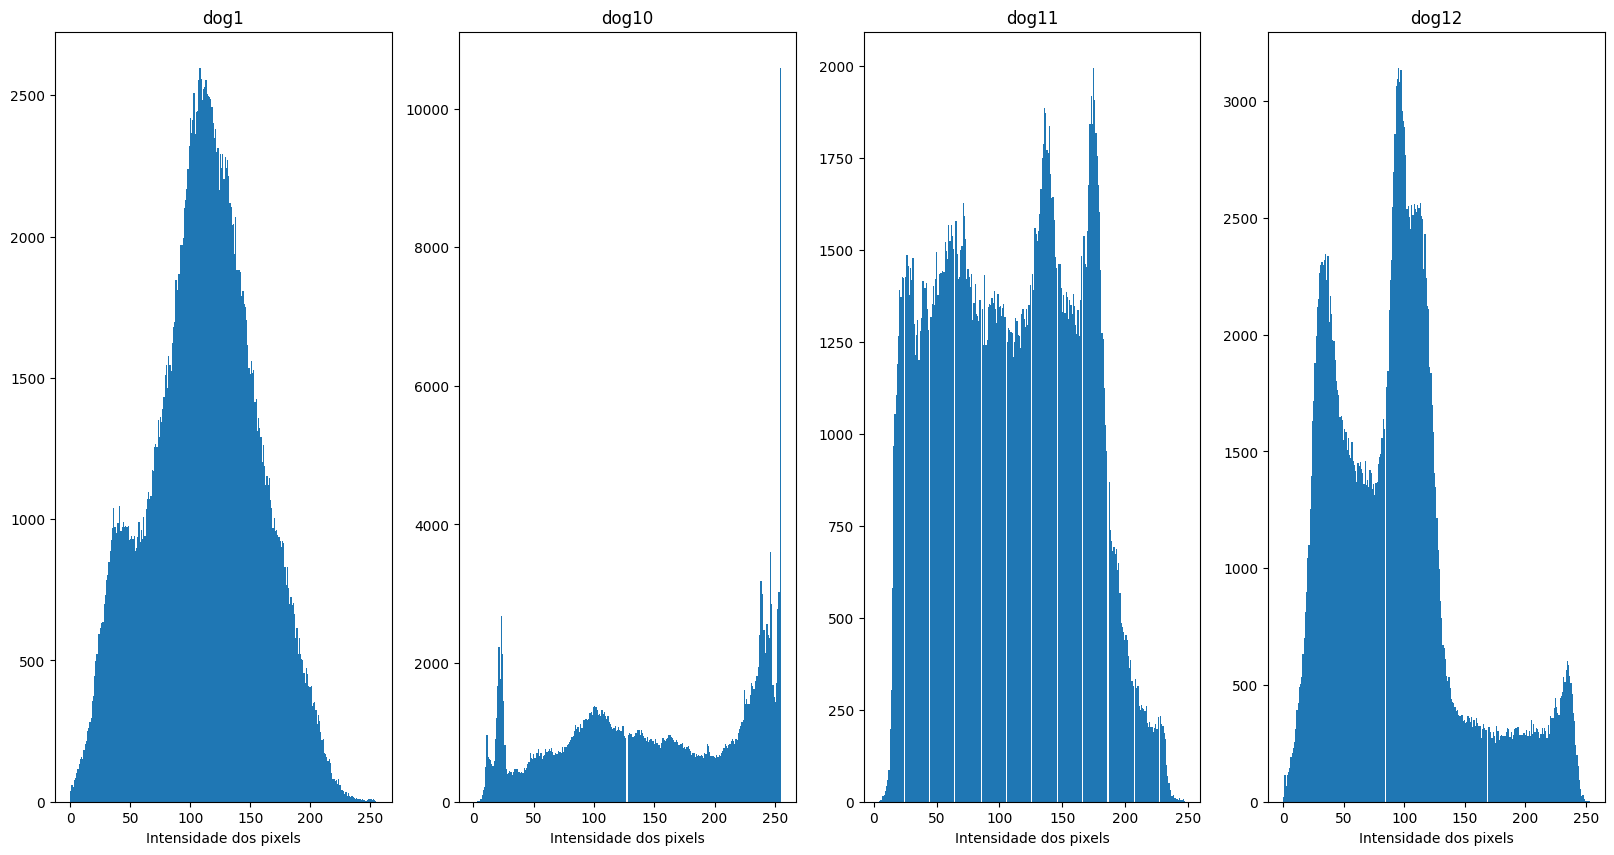

cats histograms:


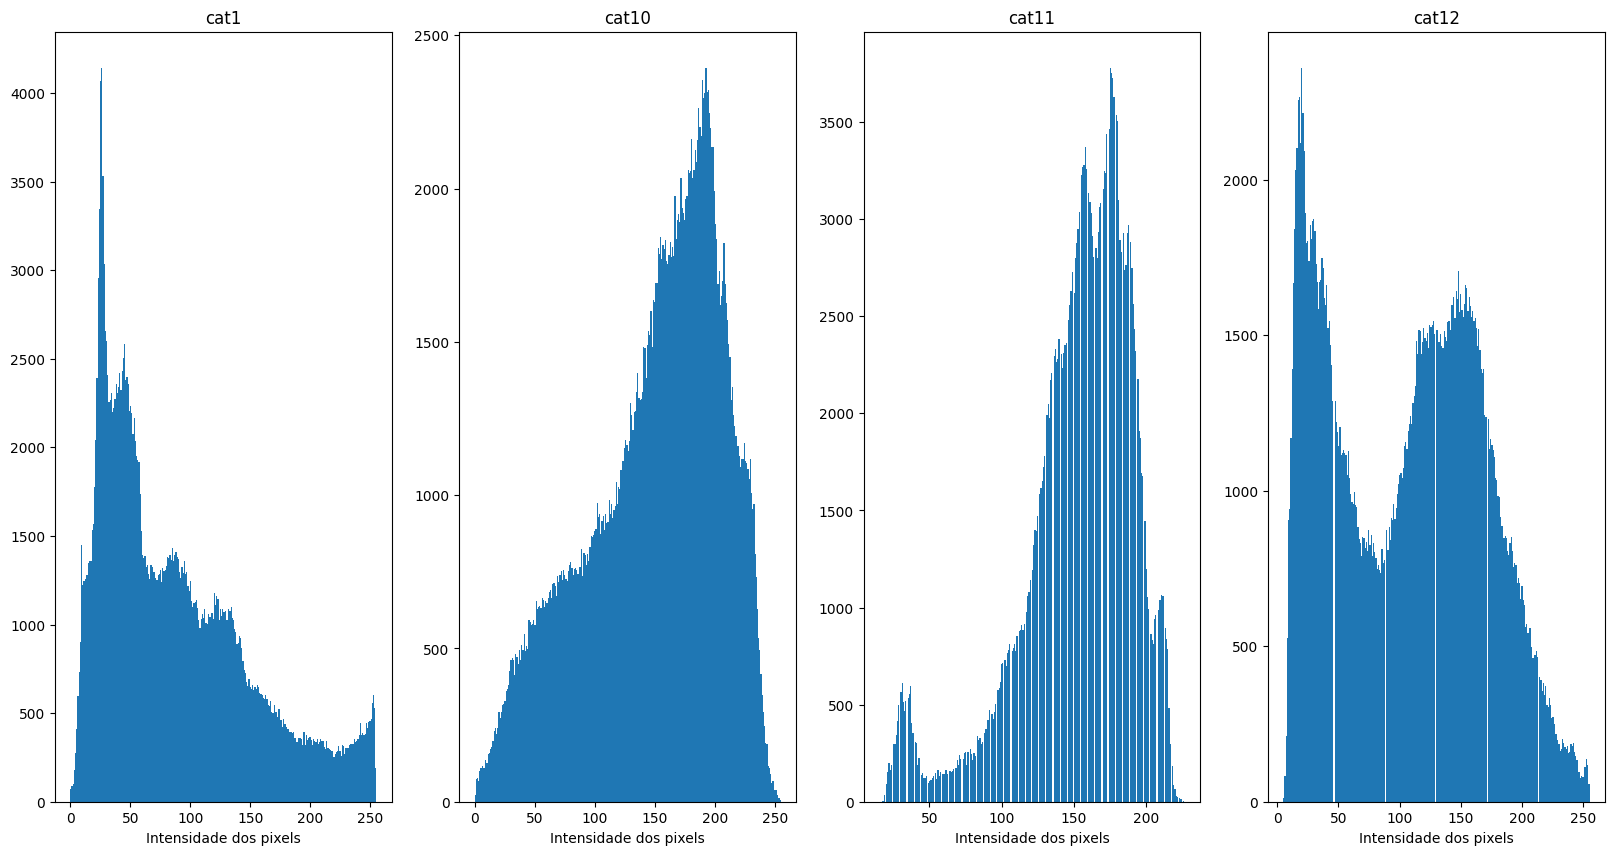

lions histograms:


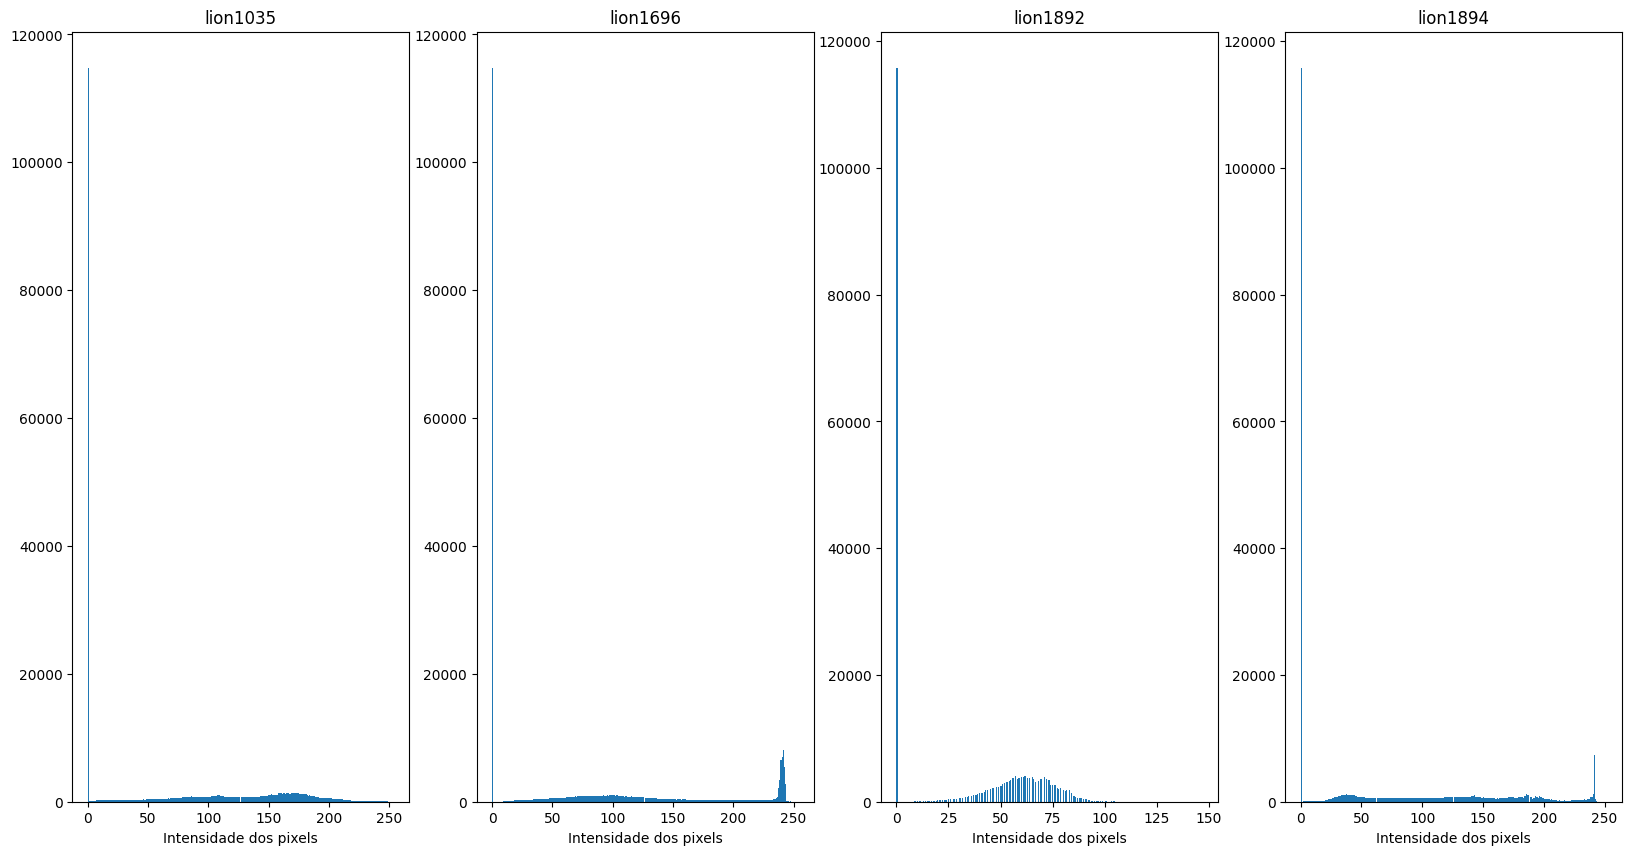

horses histograms:


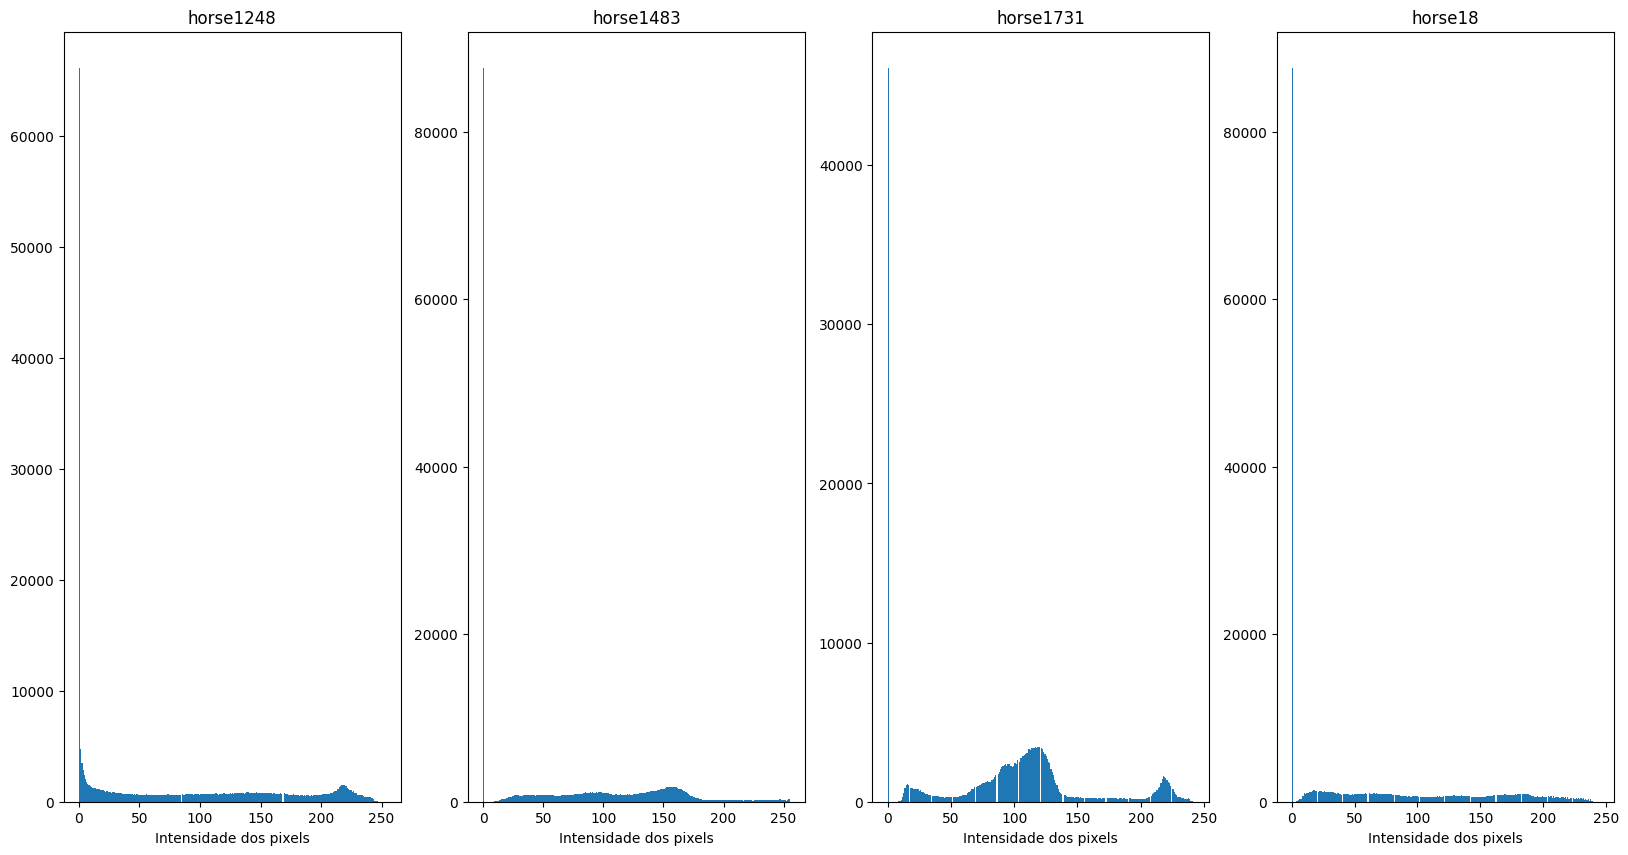

In [22]:
def show_examples_histograms(
    images: Dict[str, np.ndarray], n: int = 3, label: str = "Example"
) -> None:
    """
    Display histograms for a set of grayscale images.
    
    Args:
        images (Dict[str, np.ndarray]): Dictionary with filename as key and image array as value
        n (int): Number of histograms to display (default: 3)
        label (str): Label prefix for histogram titles (default: "Example")
    """
    # Convert dictionary items to list and take first n items
    items = list(images.items())[:n]
    plt.figure(figsize=(20, 10))
    for i, (key, img) in enumerate(items):
        plt.subplot(1, n, i + 1)
        plt.hist(img.ravel(), bins=256)
        plt.title(key)
        plt.axis("on")
        plt.xlabel("Intensidade dos pixels")


def show_examples_histograms_by_category(
    categories: List[str], 
    images: Dict[str, Dict[str, np.ndarray]], 
    n: int = 3
) -> None:
    """
    Display histograms for images from each category.
    
    Args:
        categories (List[str]): List of category names
        images (Dict[str, Dict[str, np.ndarray]]): Nested dictionary structure:
                                                  {category: {filename: image_array}}
        n (int): Number of histograms per category to display (default: 3)
    """
    for category in categories:
        print(f"{category} histograms:")
        show_examples_histograms(images[category], n=n, label=category)
        plt.show()


show_examples_histograms_by_category(
    image_categories, train_images_by_categories, n=n_examples
)

# Segmentação das Imagens

Ao aplicar técnica de Relevância, pretende-se descobrir quais partes, ou regiões, de uma imagem são mais relevantes para o processo de classificação.

O primeiro passo, é segmentar essas imagens em `k` partes.

Num primeiro momento, esse `k` será calculado dinamicamente, de forma a gerar uma quantidade razoável de pedaços, sem muito critério.

Conforme os experimentos avançarem, melhores configurações serão testadas.

In [23]:

# Get the image segmentation factor from environment variable
# Default to 4 if not set
MIN_K=int(os.getenv('IMAGE_MIN_K', 4))
MAX_K=int(os.getenv('IMAGE_MAX_K', 20))
BASE_SIZE=int(os.getenv('IMAGE_BASE_SIZE', 512))
BASE_K=int(os.getenv('IMAGE_BASE_K', 9))

print(f"MIN_K: {MIN_K}, MAX_K: {MAX_K}, BASE_SIZE: {BASE_SIZE}, BASE_K: {BASE_K}")

MIN_K: 4, MAX_K: 20, BASE_SIZE: 512, BASE_K: 9


Teste de K dinâmico:
Imagem dog1: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem dog10: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem cat1: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem cat10: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem lion1035: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem lion1696: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem horse1248: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)
Imagem horse1483: 512x512 → K=9
  Resultado: 3x3 grid (9 regiões)

Visualizando segmentação automática:


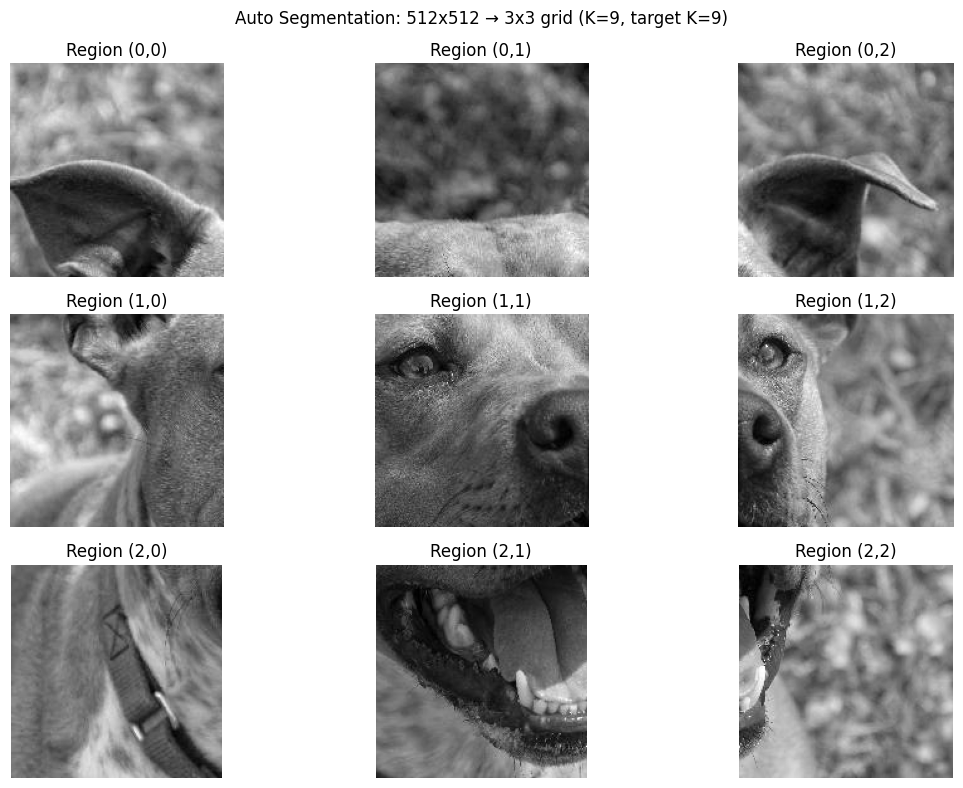

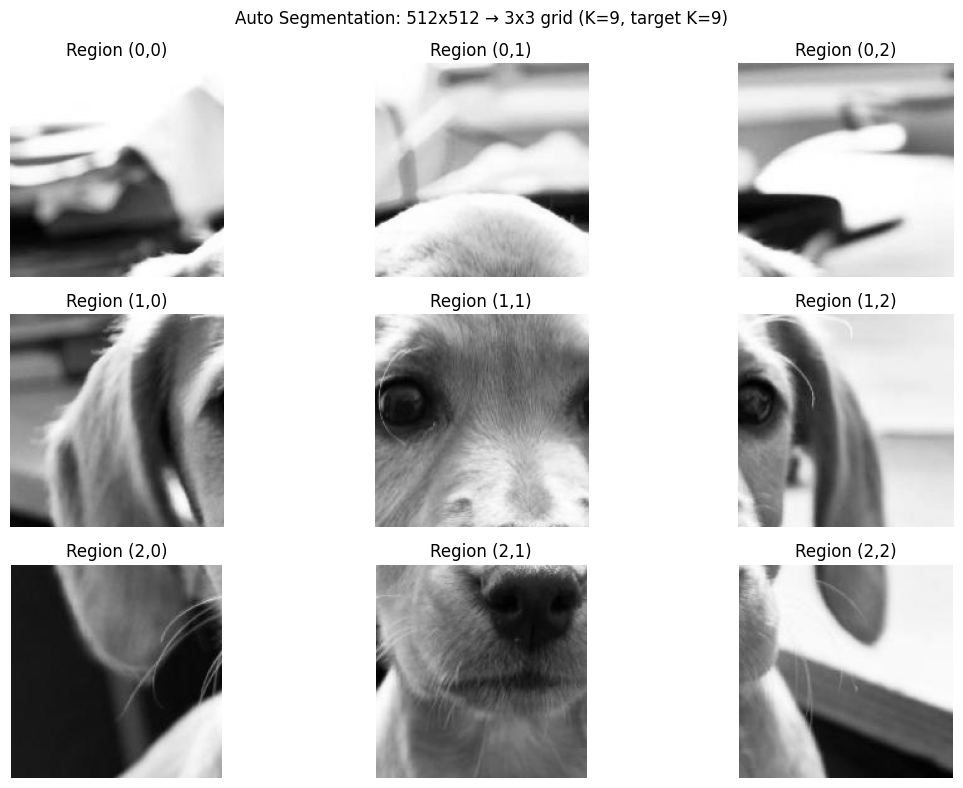

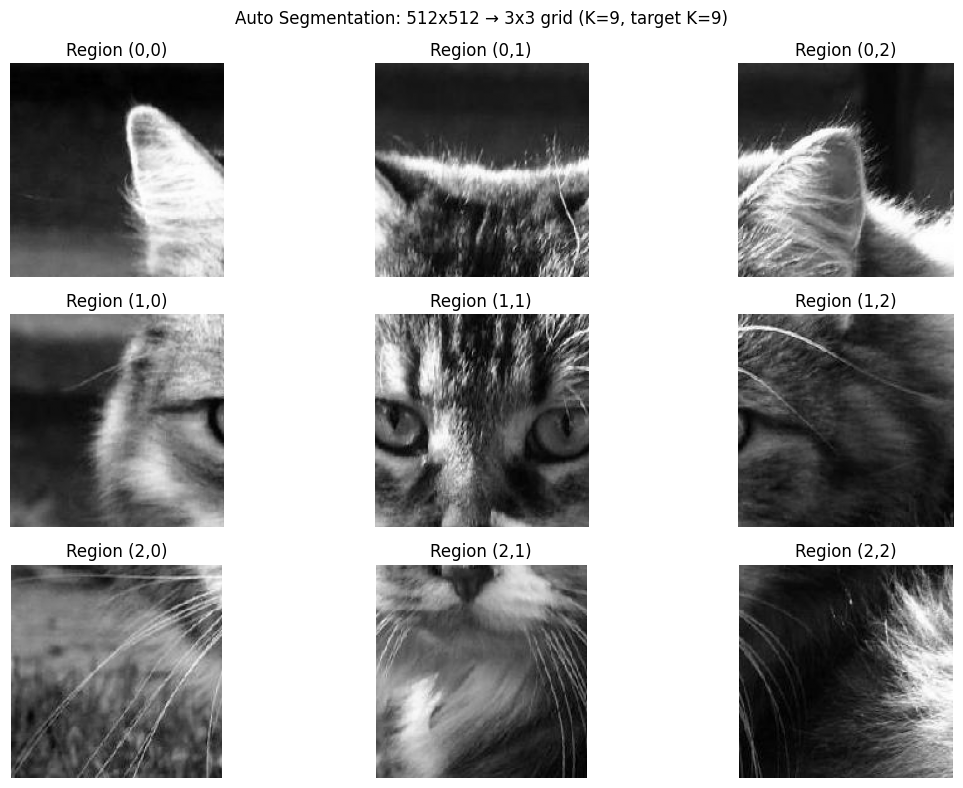

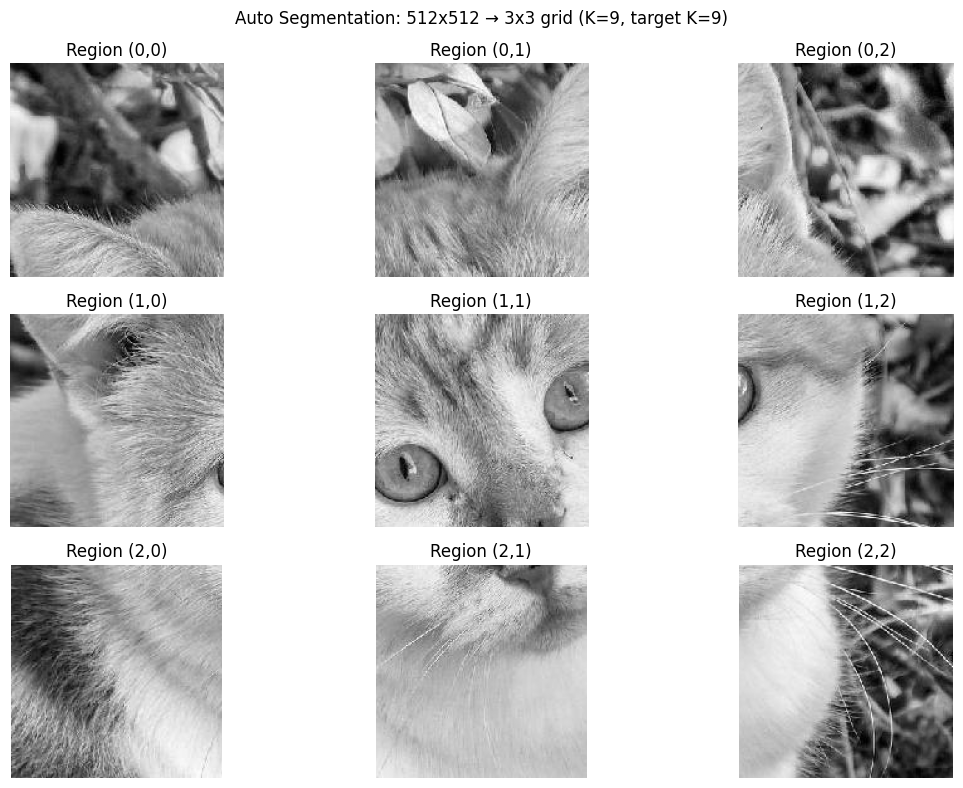

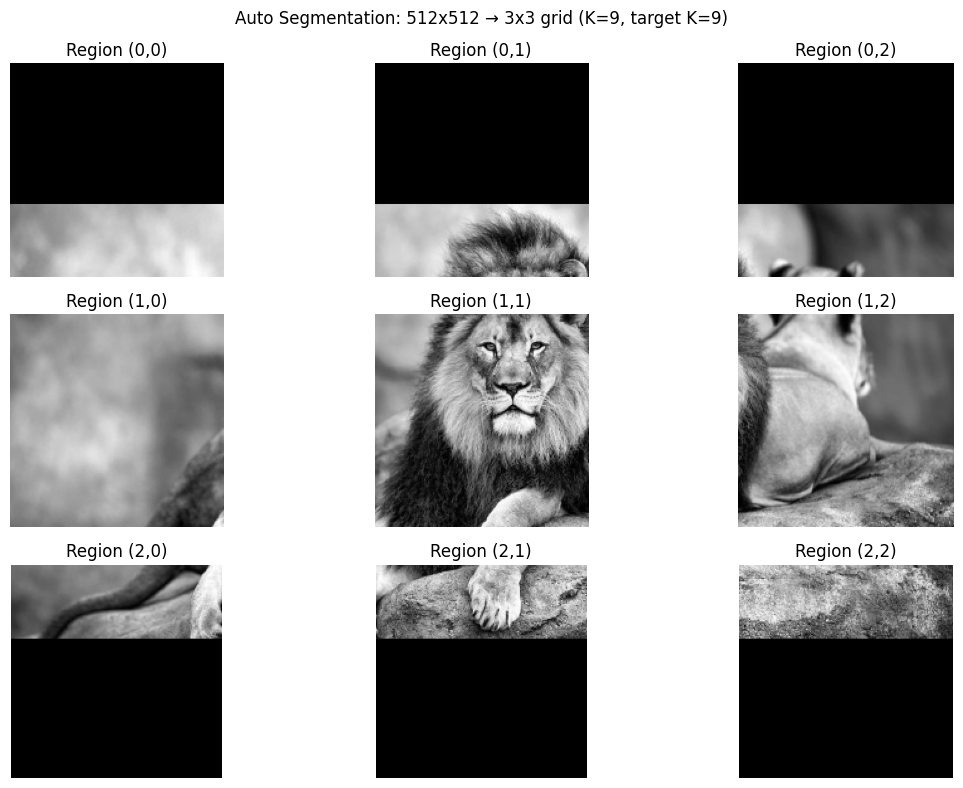

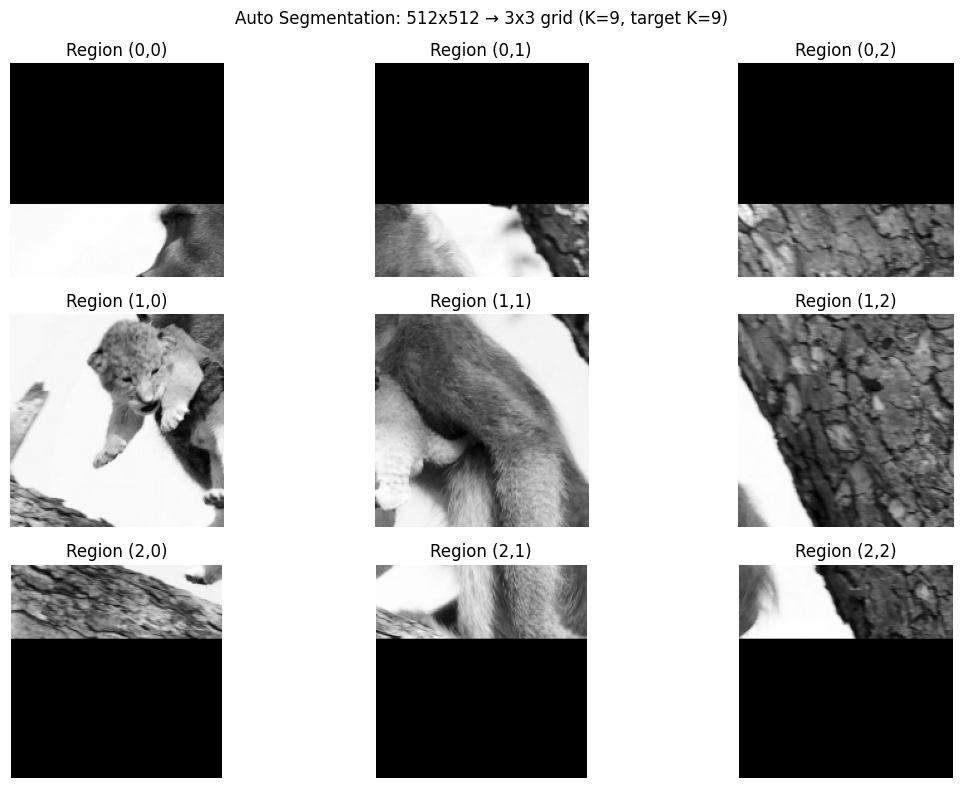

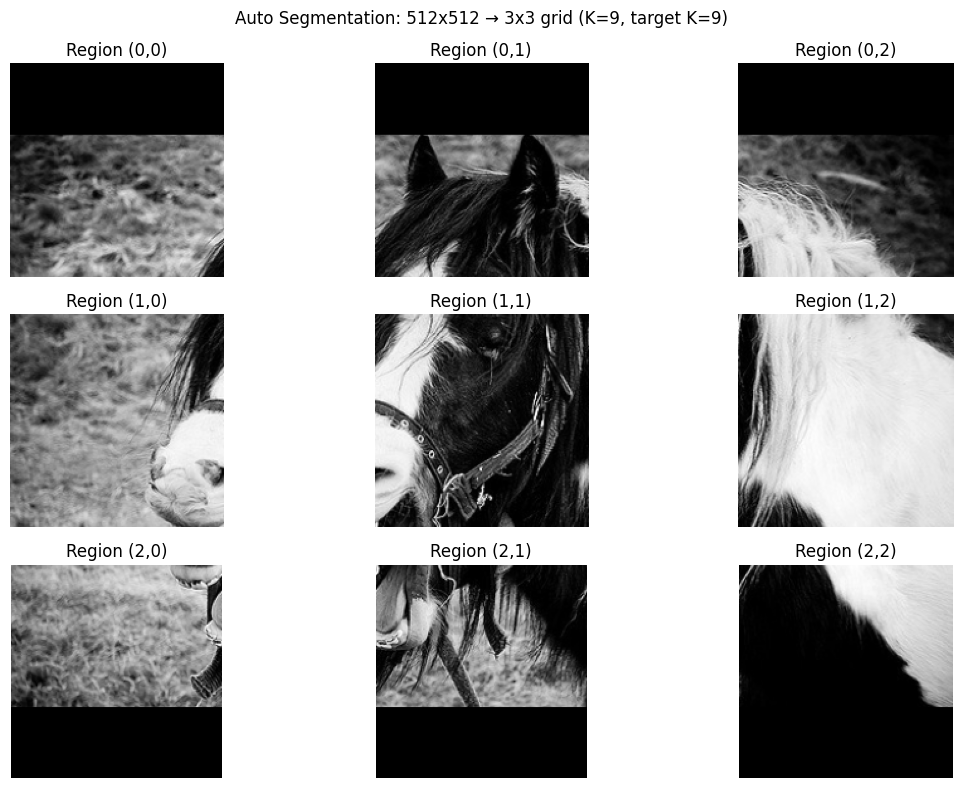

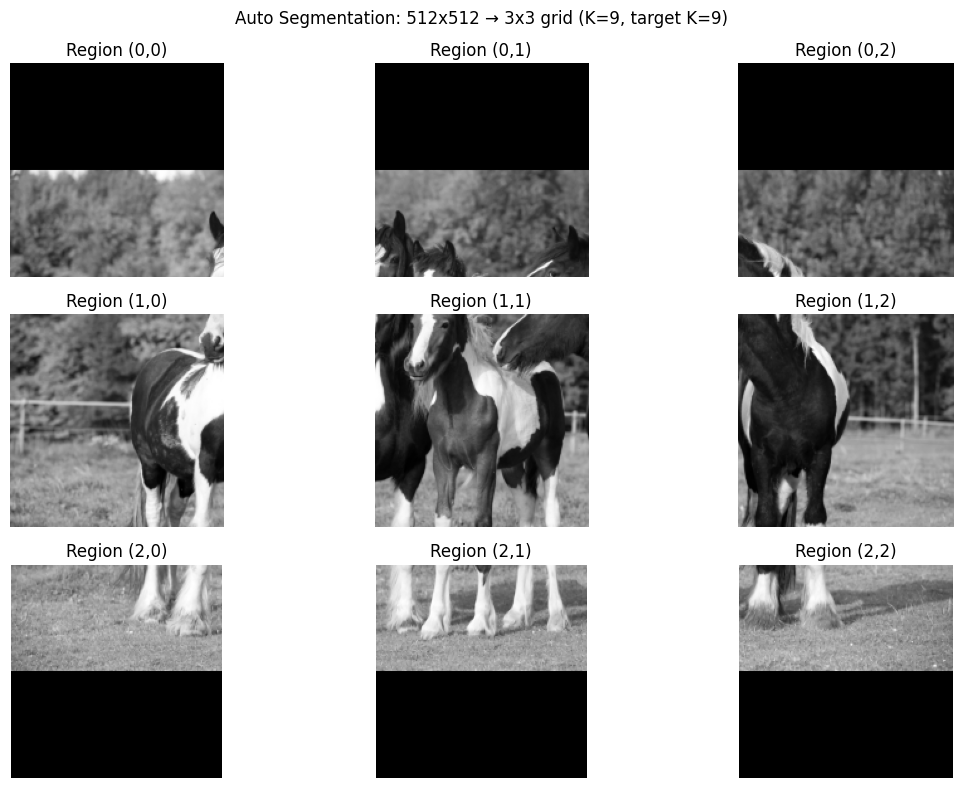

In [24]:
# Teste de segmentação automática com K dinâmico

# Carregue algumas imagens de teste
test_images = {}
for category in image_categories:
    if len(train_images_by_categories[category]) > 0:
        features_qty = list(train_images_by_categories[category].items())[:2]
        for k, v in features_qty:
            test_images[k] = v  # 2 por categoria

print("Teste de K dinâmico:")
for key, image in test_images.items():
    height, width = image.shape

    # Calcular K dinamicamente
    auto_k = calculate_dynamic_k(
        height, width, min_k=MIN_K, max_k=MAX_K, base_size=BASE_SIZE, base_k=BASE_K
    )

    print(f"Imagem {key}: {height}x{width} → K={auto_k}")

    # Segmentar automaticamente
    auto_segmented = segment_image_auto(
        image, min_k=MIN_K, max_k=MAX_K, base_size=BASE_SIZE, base_k=BASE_K
    )  # Cada imagem vira uma matriz de pedaços
    actual_regions = auto_segmented.shape[0] * auto_segmented.shape[1]
    print(
        f"  Resultado: {auto_segmented.shape[0]}x{auto_segmented.shape[1]} grid ({actual_regions} regiões)"
    )

print("\nVisualizando segmentação automática:")
for key, image in test_images.items():
    visualize_image_segmentation_auto(
        image, min_k=MIN_K, max_k=MAX_K, base_size=BASE_SIZE, base_k=BASE_K
    )

## Obter conjunto de imagens particionadas

Todas as imagens devem serem particionadas em `K` partes. Inicialmente, a quantidade dessas regiões será calculado dinamicamente.

Após o particionamento serão obtidos dois conjuntos de imagens:
 * **Imagens originais:** Utilizadas para treinar os especialistas
 * **Imagens particionadas:** Utilizadas para calcular a relevância da imagem

In [25]:
segmented_train_images = segment_images_by_category_auto(
    images_by_category=train_images_by_categories,
    min_k=MIN_K,
    max_k=MAX_K,
    base_k=BASE_K,
    base_size=BASE_SIZE,
)

all_images_segmented = merge_image_categories_dicts(segmented_train_images)

Auto-segmenting 30 images from category 'dogs' (K range: 4-20)...
  Generated average 9.0 regions per image
dogs: 270 regions total
Auto-segmenting 30 images from category 'cats' (K range: 4-20)...
  Generated average 9.0 regions per image
cats: 270 regions total
Auto-segmenting 30 images from category 'lions' (K range: 4-20)...
  Generated average 9.0 regions per image
lions: 270 regions total
Auto-segmenting 30 images from category 'horses' (K range: 4-20)...
  Generated average 9.0 regions per image
horses: 270 regions total


## Ler features já processadas anteriormente

In [26]:
import files

importlib.reload(files)

from files import load_features_from_files, save_features_to_files, verify_features_files


In [27]:

features = []
FEATURES_FILES = ['lbp.npy', 'glcm.npy', 'lpq.npy', 'labels.npy']


# Verifica se alguma feature não está escrita em disco
all_features_stored = verify_features_files(FEATURES_FILES)
all_features_stored

False

## Extrair a estrutura das imagens de treino com LBP

Cada imagem tem sua própria estrutura. Todavia, imagens de objetos similares, via de regra, terão certa semelhança entre suas estruturas. Imagens de gatos terão uma "textura" similar entre si, supostamente. O que não é esperado ocorrer entre uma imagem de um gato e um cachorro, por exemplo.  

Nesse contexto, é possível utilizar o algoritmo **LBP (Local Binary Pattern)** para extrair a estrutura/textura das imagens de treino e agrupá-las em categorias.

Para visualizar a estrutura computada das imagens pode-se montar um histograma com as informações fornececidas pelo LBP.

In [28]:
import lbp

importlib.reload(lbp)

from lbp import (
    compute_lbp_for_segments_by_categories,
)


Identified 59 characteristics for dogs
dogs histograms:


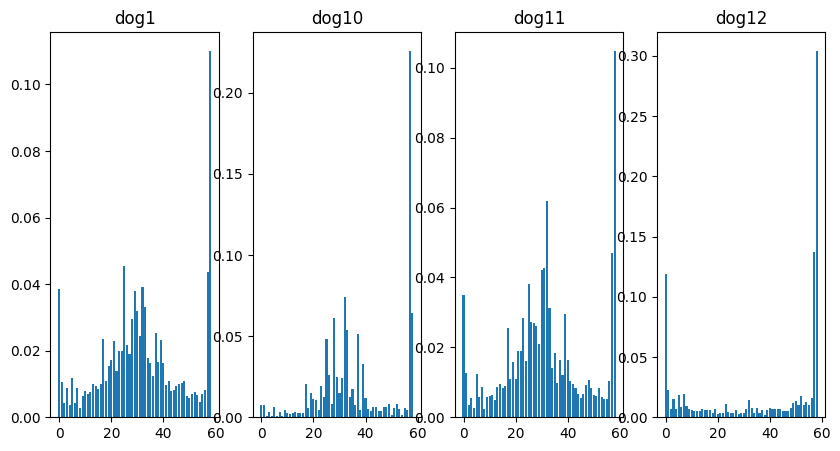

Identified 59 characteristics for cats
cats histograms:


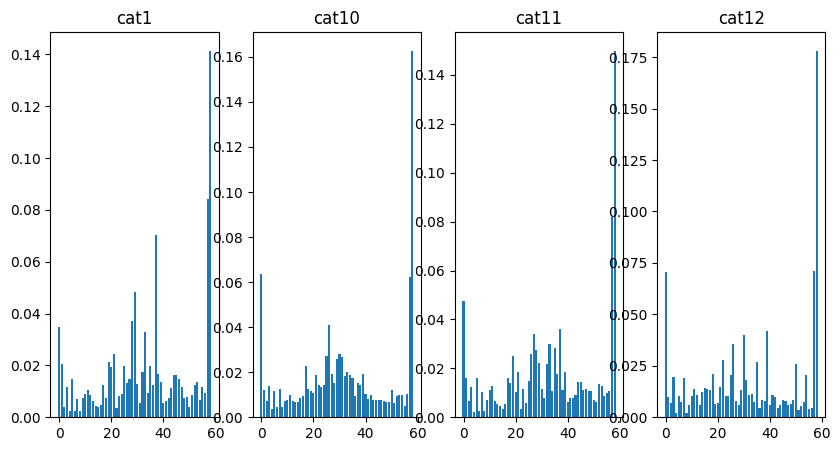

Identified 59 characteristics for lions
lions histograms:


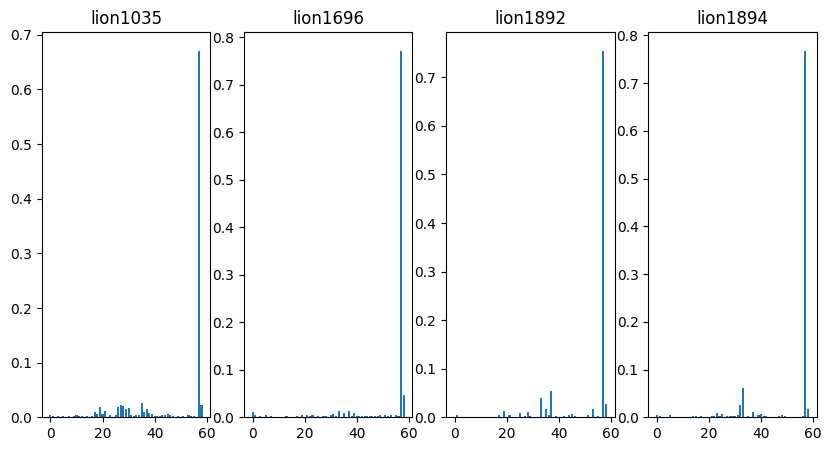

Identified 59 characteristics for horses
horses histograms:


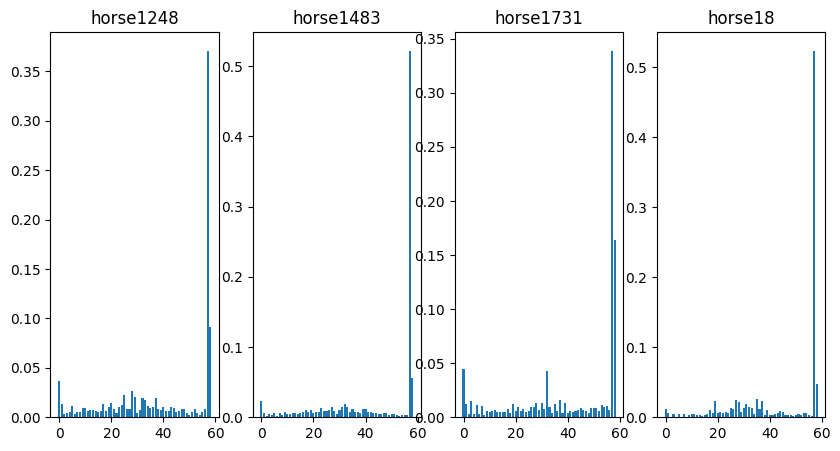

In [29]:
def show_sample_histograms(histograms: Dict[str, np.ndarray], n=3, label="Example"):
    """
    Display sample histograms from a dictionary of histograms.
    
    Args:
        histograms: Dictionary with name as key and histogram array as value
        n: Number of histograms to display
        label: Label for the plots
    """
    # Get first histogram to determine number of bins
    first_histogram = next(iter(histograms.values()))
    vals = range(len(first_histogram))
    
    plt.figure(figsize=(10, 5))

    for i, (name, sample) in enumerate(list(histograms.items())[:n]):
        plt.subplot(1, n, i + 1)
        plt.bar(vals, sample)
        plt.title(f"{name}")
        plt.axis("on")


def show_sample_histograms_by_category(
    categories: list[str], 
    lbps_dict_histograms: Dict[str, Dict[str, np.ndarray]], 
    n: int = 3
) -> None:
    """
    Display sample histograms for each category.
    
    Args:
        categories: List of category names
        lbps_dict_histograms: Dictionary structure {category: {image_name: features_array}}
        n: Number of samples per category
    """
    for category in categories:
        category_data = lbps_dict_histograms[category]
        
        if not category_data:
            print(f"No data available for category {category}")
            continue
            
        # Get first sample to determine characteristics count
        first_sample = next(iter(category_data.values()))
        
        # Check if it's a single histogram or array of histograms
        if len(first_sample.shape) == 1:
            # Single histogram per image
            x = first_sample.shape[0]
        else:
            # Array of histograms (segmented image case)
            x = first_sample.shape[1]  # Number of features per segment
            
        print(f"Identified {x} characteristics for {category}")
        print(f"{category} histograms:")
        
        # For segmented images, we need to show the first histogram of each image
        display_histograms = {}
        for image_name, features in list(category_data.items())[:n]:
            if len(features.shape) == 1:
                # Single histogram
                display_histograms[image_name] = features
            else:
                # Array of histograms - take the first one
                display_histograms[image_name] = features[0]
        
        show_sample_histograms(display_histograms, n=n, label=category)
        plt.show()


if not all_features_stored:
    # settings for LBP
    radius = 2
    n_pixels = 8

    lbps_by_categories = compute_lbp_for_segments_by_categories(
        image_categories, segmented_train_images, radius, n_pixels
    )

    show_sample_histograms_by_category(
        image_categories, lbps_by_categories, n=n_examples
    )

    features.append(lbps_by_categories)

### Calcular matriz GLCM

O primeiro passo do algoritmo GLCM é montar a matriz de níveis de cinza, onde o número de linhas e colunas é igual ao número de níveis de cinza.

In [30]:
import glcm

from glcm import (
    parallel_calculate_glcm_for_each_category
)

importlib.reload(glcm)


<module 'glcm' from '/home/afmireski/Documentos/BCC/TCC/tcc_image_classification_by_relevance_of_regions/glcm.py'>

In [31]:

GLCM_DISTANCES = [1, 3, 5]
GLCM_ANGLES = np.deg2rad([0, 90, 180, 270])
GLCM_LEVELS = None
GLCM_FEATURES = [
    "contrast",
    "dissimilarity",
    "homogeneity",
    "ASM",
    "energy",
    "correlation",
]

glcms_by_category = parallel_calculate_glcm_for_each_category(
    image_categories, segmented_train_images, GLCM_DISTANCES, GLCM_ANGLES, GLCM_FEATURES, GLCM_LEVELS
)


features.append(glcms_by_category)

### Extrair texturas das matrizes

Após computar as matrizes de nível de cinza, o próximo passo é extrair as características/texturas dessas matrizes, utilizando algumas das técnicas disponíveis: "contrast",    "dissimilarity", "homogeneity", "ASM","energy","correlation".

Em média são extraídas 72 características de cada imagem, utilizando a configuração escolhida aqui.

Abaixo serão exibidas as características da primeira imagem de cada classe de treino para comparação:

Identified 72 GLCM features for dogs
Identified 72 GLCM features for cats
Identified 72 GLCM features for lions
Identified 72 GLCM features for horses


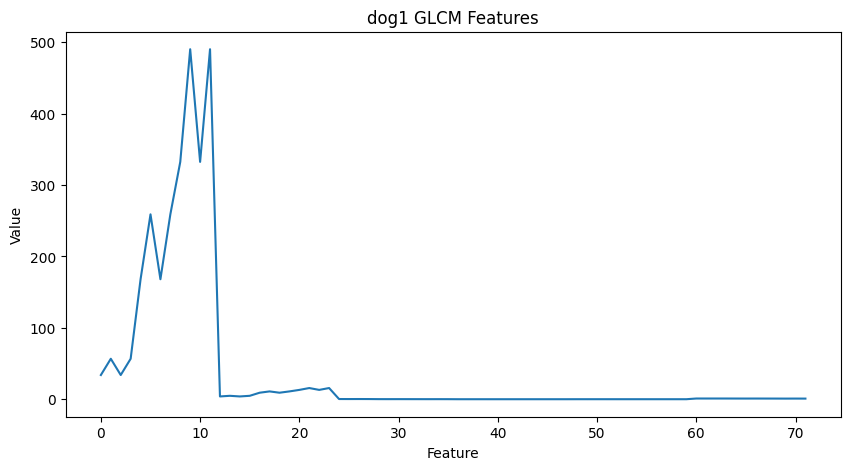

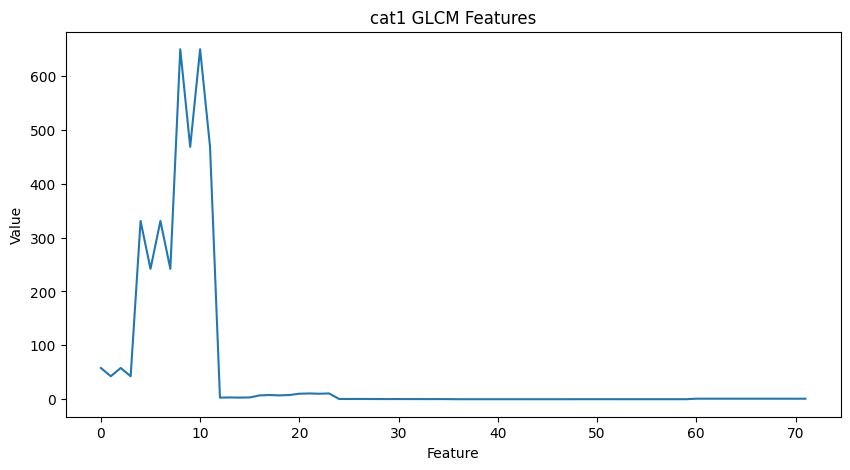

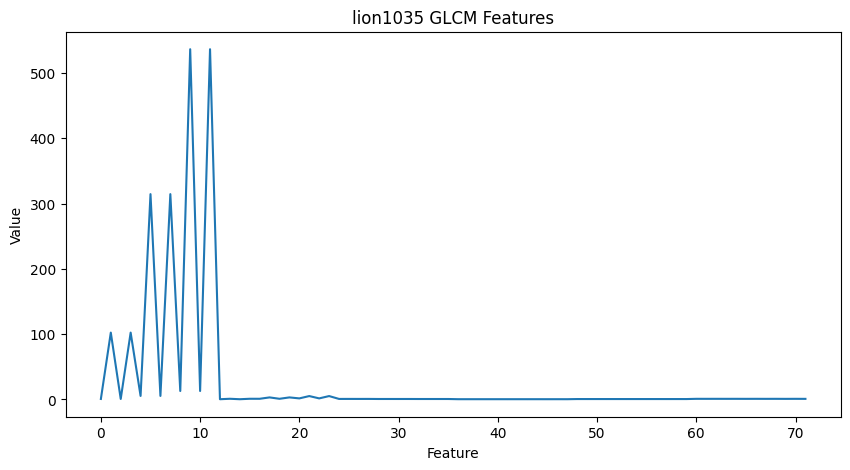

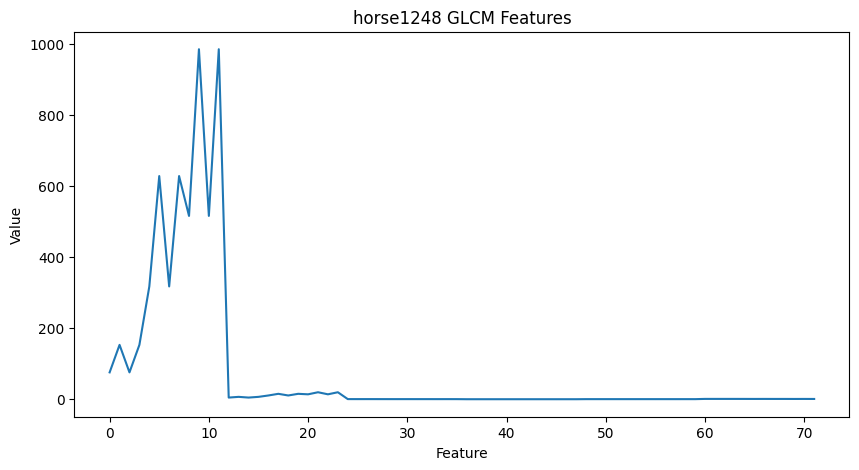

In [32]:
def show_glcm_features_for_each_category(categories: list, glcms: Dict[str, Dict[str, np.ndarray]]):
    for category in categories:
        category_data = glcms[category]

        if not category_data:
            print(f"No data available for category {category}")
            continue

        first_sample = next(iter(category_data.values()))

        # Check if it's a single histogram or array of histograms
        if len(first_sample.shape) == 1:
            # Single histogram per image
            features_qty = first_sample.shape[0]
        else:
            # Array of histograms (segmented image case)
            features_qty = first_sample.shape[1]  # Number of features per segment

        print(f"Identified {features_qty} GLCM features for {category}")

        image_name, features = list(category_data.items())[:1][0]

        if len(features.shape) == 1:
            # Single glcm
            display_glcm = features
        else:
            # Array of glcms - take the first one
            display_glcm = features[0]

        plt.figure(figsize=(10, 5))
        plt.plot(display_glcm)
        plt.title(f"{image_name} GLCM Features")
        plt.xlabel("Feature")
        plt.ylabel("Value")
    plt.show()

show_glcm_features_for_each_category(image_categories, glcms_by_category)

## Extrair características utilizando LPQ

In [33]:
import lpq

importlib.reload(lpq)

from lpq import extract_lpq_features_for_each_category

In [34]:
lpqs_dict = extract_lpq_features_for_each_category(image_categories, segmented_train_images)

features.append(lpqs_dict)

# Matriz de Características

Dicionários são pouco práticos para se armazenar informações que serão utilizadas para treinar modelos de Aprendizado de Máquina. Nesse contexto, vetores e matrizes são muito mais amplamente utilizados. 
Assim, dado um vetor de `N` rótulos, por exemplo, `images_categories`, é possível imaginar a seguinte estrutura:
- Um vetor de `N` posições: `images`.
    - Cada posição do vetor corresponde ao rótulo na mesma posição em `images_categories`.
- Cada posição contém um array de duas posições:
    - A primeira posição contém as matriz de características extraídas usando o `LBP`
    - A segunda posição contém a matriz de características extraídas usando o `GLCM`
    - A terceira posição contém um vetor de rótulos.
- Cada coluna da matriz é uma característica.
- Cada linha da matriz corresponde a uma imagem.


In [35]:
import tools.data as tdt
importlib.reload(tdt)

from tools.data import (
    generate_texture_dicts,
    show_features_summary
)

In [36]:
(sets, labels, true_images_labels) = generate_texture_dicts(
    image_categories, features[0], features[1], features[2]
)

Categoria: dogs, Número de elementos: 30
Categoria: cats, Número de elementos: 30
Categoria: lions, Número de elementos: 30
Categoria: horses, Número de elementos: 30
Categoria: dogs, Número de elementos: 30
Categoria: cats, Número de elementos: 30
Categoria: lions, Número de elementos: 30
Categoria: horses, Número de elementos: 30
Categoria: dogs, Número de elementos: 30
Categoria: cats, Número de elementos: 30
Categoria: lions, Número de elementos: 30
Categoria: horses, Número de elementos: 30


Ao final do processo, é esperado que para cada imagem sejam identificadas 59 características utilizando o LBP, 72 utilizando o GLCM e 256 utilizando o LPQ.
Uma função que quantifica e resume as informações das imagens de entrada existe abaixo.

In [37]:
show_features_summary(sets, labels)

RESUMO DOS CONJUNTOS DE FEATURES
📊 Total de imagens: 120
🔧 Total de conjuntos gerados: 7
📋 Labels únicos: {'lions', 'cats', 'dogs', 'horses'}

🔹 LBP:
   📁 Imagens: 120
   🧩 Segmentos por imagem: 9
   🧱 Total de segmentos do conjunto: 1080
   🎯 Features por segmento: 59
   📈 Total features por imagem: 531

🔹 GLCM:
   📁 Imagens: 120
   🧩 Segmentos por imagem: 9
   🧱 Total de segmentos do conjunto: 1080
   🎯 Features por segmento: 72
   📈 Total features por imagem: 648

🔹 LPQ:
   📁 Imagens: 120
   🧩 Segmentos por imagem: 9
   🧱 Total de segmentos do conjunto: 1080
   🎯 Features por segmento: 256
   📈 Total features por imagem: 2304

🔹 LBP+GLCM:
   📁 Imagens: 120
   🧩 Segmentos por imagem: 9
   🧱 Total de segmentos do conjunto: 1080
   🎯 Features por segmento: 131
   📈 Total features por imagem: 1179

🔹 LBP+LPQ:
   📁 Imagens: 120
   🧩 Segmentos por imagem: 9
   🧱 Total de segmentos do conjunto: 1080
   🎯 Features por segmento: 315
   📈 Total features por imagem: 2835

🔹 GLCM+LPQ:
   📁 Imag

In [38]:
# Limpeza de variáveis desnecessárias após o cálculo das features
# Uma vez que as features estão calculadas e salvas, podemos liberar memória
# removendo variáveis intermediárias que não serão mais utilizadas

import gc  # Garbage collector

print("Limpando variáveis desnecessárias...")
print(f"Variáveis antes da limpeza: {len(locals())} variáveis locais")

# Variáveis de dados intermediários que podem ser removidas
variables_to_clean = [
    # Dados de segmentação (já processados)
    'segmented_train_images',
    
    # Dados intermediários de features por categoria (já consolidados)
    'lbps_by_categories',
    'glcms_by_category', 
    'lpq_features_dict',
    
    # Variáveis antigas que não existem mais
    'lbps_dict_categories', 
    'lbps_histograms_by_categories',
    'glcm_features_by_category',
    
    # Imagens de teste usadas para demonstração
    'test_images',
    
    # Variáveis temporárias do processo de merge (se existirem)
    'merge_lbp', 'merge_glcm', 'merge_lpq', 'merge_labels',
    'data',
    
    # Arrays de features individuais antigos (estrutura mudou)
    'X_lbp', 'X_glcm', 'X_lpq',
    
    # Conjuntos antigos (estrutura mudou para combined_sets)
    'set_lbp', 'set_glcm', 'set_lpq', 'set_lbp_glcm', 
    'set_lbp_lpq', 'set_glcm_lpq', 'set_lbp_glcm_lpq',
    
    # Outras variáveis temporárias
    'auto_k', 'auto_segmented', 'actual_regions',
    'height', 'width', 'i', 'image',
    
    # Variáveis de configuração temporárias
    'radius', 'n_pixels', 'n_examples'
]

# Conta quantas variáveis foram realmente removidas
removed_count = 0
for var_name in variables_to_clean:
    if var_name in locals():
        del locals()[var_name]
        removed_count += 1
        print(f"  ✓ Removida: {var_name}")

# Remove também variáveis globais se existirem
for var_name in variables_to_clean:
    if var_name in globals():
        del globals()[var_name]

# Força a coleta de lixo para liberar memória imediatamente
gc.collect()

print(f"\n✓ Limpeza concluída!")
print(f"  - {removed_count} variáveis removidas")
print(f"  - Memória liberada pela coleta de lixo")
print(f"  - Variáveis após limpeza: {len(locals())} variáveis locais")

# Mostra as principais variáveis que permanecem (estrutura atualizada)
essential_vars = [
    'image_categories', 'train_images_by_categories',
    'combined_sets', 'labels', 'all_features_stored',
    'GLCM_DISTANCES', 'GLCM_ANGLES', 'GLCM_FEATURES'
]

print("\n📋 Principais variáveis mantidas:")
for var in essential_vars:
    if var in locals():
        if hasattr(locals()[var], 'shape'):
            print(f"  ✓ {var}: {type(locals()[var]).__name__} {getattr(locals()[var], 'shape', '')}")
        elif isinstance(locals()[var], (list, dict)):
            print(f"  ✓ {var}: {type(locals()[var]).__name__} (tamanho: {len(locals()[var])})")
        else:
            print(f"  ✓ {var}: {type(locals()[var]).__name__}")

print("\n💡 Variáveis limpas com sucesso! Agora você pode prosseguir com o treinamento dos modelos.")
print("🔄 Nova estrutura: combined_sets contém todos os conjuntos de features combinados.")

Limpando variáveis desnecessárias...
Variáveis antes da limpeza: 148 variáveis locais
  ✓ Removida: segmented_train_images
  ✓ Removida: lbps_by_categories
  ✓ Removida: glcms_by_category
  ✓ Removida: test_images
  ✓ Removida: auto_k
  ✓ Removida: auto_segmented
  ✓ Removida: actual_regions
  ✓ Removida: height
  ✓ Removida: width
  ✓ Removida: image
  ✓ Removida: radius
  ✓ Removida: n_pixels
  ✓ Removida: n_examples

✓ Limpeza concluída!
  - 13 variáveis removidas
  - Memória liberada pela coleta de lixo
  - Variáveis após limpeza: 138 variáveis locais

📋 Principais variáveis mantidas:
  ✓ image_categories: list (tamanho: 4)
  ✓ train_images_by_categories: dict (tamanho: 4)
  ✓ labels: list (tamanho: 120)
  ✓ all_features_stored: bool
  ✓ GLCM_DISTANCES: list (tamanho: 3)
  ✓ GLCM_ANGLES: ndarray (4,)
  ✓ GLCM_FEATURES: list (tamanho: 6)

💡 Variáveis limpas com sucesso! Agora você pode prosseguir com o treinamento dos modelos.
🔄 Nova estrutura: combined_sets contém todos os conjunto

# Dividir o conjunto de dados

Para esse projeto, será utilizada a técnica de validação cruzada em K-Partições, visando obter uma ideia melhor do desempenho do modelo, treinando-o com todos os dados.
Após alguns testes, foi escolhido `K=x`.

A ideia, é que hajam vários modelos, cada um treinado com um tipo de conjunto de dados:
- LBP
- GLCM
- LPQ
- LBP + GLCM
- LBP + LPQ
- GLCM + LPQ
- LBP + GLCM + LBP

Para facilitar o armazenamento, cada conjunto será um vetor com as seguintes características:
- Primeira posição será o conjunto total das features.
- Segunda posição será os rótulos


In [39]:
# Importa bilbliotecas que serão necessárias para dividir e padronizar dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Número de folds para a validação cruzada
K_FOLDS = 5 

In [40]:
# Extraí os conjuntos e os labels da estrutura de dados:
[X_lbp, X_glcm, X_lpq, X_lbp_glcm, X_lbp_lpq, X_glcm_lpq, X_lbp_glcm_lpq] = sets
    
set_lbp = (X_lbp, labels)
set_glcm = (X_glcm, labels)
set_lpq = (X_lpq, labels)
set_lbp_glcm = (X_lbp_glcm, labels)
set_lbp_lpq = (X_lbp_lpq, labels)
set_glcm_lpq = (X_glcm_lpq, labels)
set_lbp_glcm_lpq = (X_lbp_glcm_lpq, labels)

# Conjuntos de Dados Especialistas

Um especialista é alguém especializado em reconhecer algo, no contexto desse projeto, cada especialista deve ser capaz de reconhecer uma dada classe com maestria.

Nesse cenário, são necessários conjuntos de dados customizados para treiná-los.

Um conjunto de dados especialista possuí somente dois rótulos: `classe` e `não classe`.

Então, para cada conjunto de características extraídos acima, serão gerados N conjuntos de dados especialistas, um para cada classe.

In [41]:
import tools.specialists as sp

importlib.reload(sp)

from tools.specialists import (
    build_specialist_set_for_many_classes
)


In [42]:
print(f"Classes: {image_categories}")

sp_lbp_sets = build_specialist_set_for_many_classes(X_lbp, labels, image_categories)
sp_glcm_sets = build_specialist_set_for_many_classes(X_glcm, labels, image_categories)
sp_lpq_sets = build_specialist_set_for_many_classes(X_lpq, labels, image_categories)
sp_lbp_glcm_sets = build_specialist_set_for_many_classes(X_lbp_glcm, labels, image_categories)
sp_lbp_lpq_sets = build_specialist_set_for_many_classes(X_lbp_lpq, labels, image_categories)
sp_glcm_lpq_sets = build_specialist_set_for_many_classes(X_glcm_lpq, labels, image_categories)
sp_lbp_glcm_lpq_sets = build_specialist_set_for_many_classes(X_lbp_glcm_lpq, labels, image_categories)


Classes: ['dogs', 'cats', 'lions', 'horses']
Class dogs: 30 positive samples, 90 negative samples
Specialist summary for class dogs
Class features shape: (9, 59)
Class labels shape: 30
No class features shape: (9, 59)
No class labels shape: 90
Class cats: 30 positive samples, 90 negative samples
Specialist summary for class cats
Class features shape: (9, 59)
Class labels shape: 30
No class features shape: (9, 59)
No class labels shape: 90
Class lions: 30 positive samples, 90 negative samples
Specialist summary for class lions
Class features shape: (9, 59)
Class labels shape: 30
No class features shape: (9, 59)
No class labels shape: 90
Class horses: 30 positive samples, 90 negative samples
Specialist summary for class horses
Class features shape: (9, 59)
Class labels shape: 30
No class features shape: (9, 59)
No class labels shape: 90
Class dogs: 30 positive samples, 90 negative samples
Specialist summary for class dogs
Class features shape: (9, 72)
Class labels shape: 30
No class feat

# Divisão dos Dados

Para garantir que todos os modelos utilizarão os mesmos dados, é ideal realizar o split das FOLDs antes. Então, a ideia é gerar K tuplas, onde cada elemento corresponde a uma fold.

In [43]:
importlib.reload(tdt)

from tools.data import (
    prepare_sets_for_classification,
)

In [44]:
from sklearn.model_selection import StratifiedKFold

def split_data_in_folds_sklearn(dataset, k_folds=5):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    [X, y] = dataset

    folds = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        folds.append(((X_train, y_train), (X_test, y_test)))

    return folds

Extraímos as folds de cada um dos conjuntos de dados que temos:

In [45]:
final_sp_lbp_sets = prepare_sets_for_classification(sp_lbp_sets, k_folds=K_FOLDS)
final_sp_glcm_sets = prepare_sets_for_classification(sp_glcm_sets, k_folds=K_FOLDS)
final_sp_lpq_sets = prepare_sets_for_classification(sp_lpq_sets, k_folds=K_FOLDS)
final_sp_lbp_glcm_sets = prepare_sets_for_classification(sp_lbp_glcm_sets, k_folds=K_FOLDS)
final_sp_lbp_lpq_sets = prepare_sets_for_classification(sp_lbp_lpq_sets, k_folds=K_FOLDS)
final_sp_glcm_lpq_sets = prepare_sets_for_classification(sp_glcm_lpq_sets, k_folds=K_FOLDS)
final_sp_lbp_glcm_lpq_sets = prepare_sets_for_classification(sp_lbp_glcm_lpq_sets, k_folds=K_FOLDS)


📊 Total imagens classe: 30
📊 Total imagens não-classe: 90
🔄 Dividindo em 5 folds...
  Fold 0: 6 classe, 18 não-classe
  Fold 1: 6 classe, 18 não-classe
  Fold 2: 6 classe, 18 não-classe
  Fold 3: 6 classe, 18 não-classe
  Fold 4: 6 classe, 18 não-classe

🔧 Construindo fold 0...
  ✅ Treino: 24 classe + 72 não-classe = 96
  ✅ Teste: 6 classe + 18 não-classe = 24

🔧 Construindo fold 1...
  ✅ Treino: 24 classe + 72 não-classe = 96
  ✅ Teste: 6 classe + 18 não-classe = 24

🔧 Construindo fold 2...
  ✅ Treino: 24 classe + 72 não-classe = 96
  ✅ Teste: 6 classe + 18 não-classe = 24

🔧 Construindo fold 3...
  ✅ Treino: 24 classe + 72 não-classe = 96
  ✅ Teste: 6 classe + 18 não-classe = 24

🔧 Construindo fold 4...
  ✅ Treino: 24 classe + 72 não-classe = 96
  ✅ Teste: 6 classe + 18 não-classe = 24

🎉 5 folds construídos com sucesso!
🔄 Convertendo folds para formato de classificação...

📂 Processando fold 0...
  🏋️ Processando dados de treino...
  🧪 Processando dados de teste...
  ✅ Treino: 864 i

# Modelo KNN

Um dos algoritmos supervisionados mais simples é o KNN (K-Nearest Neighbor), K Vizinhos mais Próximos em tradução livre.
Ele parte da ideia de que dados que pertencem a um mesmo conjunto estarão próximos entre si, então, é seguro presumir que um novo dado pertencerá ao conjunto com mais elementos similares na região.  
Basicamente é o ditado: `"Diga-me com quem andas e te direi quem és."`.  

Partindo para uma explicação mais técnica, o `k` é um valor que define a zona de busca a ser considerada a partir do novo elemento.  
Dado esse novo elemento, será computada a distância entre o novo registro e cada ponto do conjunto, registrando-as num vetor de distância e relacionando-as com o label correspondente.
Depois, esse vetor será ordenado, tendo com base as distâncias. Indo dos mais próximos para os mais distantes.
Após a ordenação, será utilizado o valor de `k` para selecionar os `k` primeiros elementos do vetor, fazendo o cálculo de frequência para cada categoria.
A categoria com maior frequência será a escolhida como categoria do novo elemento.

## Sobre o valor de K
- Se `k` for muito pequeno (`k=1`), a classificação pode ser sensível a ruídos.
- Se `k` for muito grande, podem ser incluídos elementos de outras classes.
- `k` ímpares garantem que não haverá empates.

## Sobre o cálculo de distâncias
É possível mudar a fórmula do cálculo da distância, pois dependendo do conjunto de dados, certas fórmulas se saem melhores do que outras. Alguns exemplos:
- Euclidiana
- Manhattan
- City Block



In [46]:
# Importa as bibliotecas do KNN
from sklearn.neighbors import KNeighborsClassifier

# Bibliotecas úteis para treinamento dos modelos
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


import utils

importlib.reload(utils)

from utils import show_predict_infos

Uma boa predição depende dos parâmetros utilizados, nesse sentido, é desejado utilizar sempre os melhores parâmetros para se obter o melhor resultado possível. É para descobrir quais são esses parâmetros que serve o conjunto de validação.

In [47]:
K_ARRAY = [1, 3, 5, 7, 9]
DISTANCE_METRICS = ["euclidean", "manhattan", "minkowski"]

def tune_knn(k_array, distance_metrics):

    knn = KNeighborsClassifier()

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "knn__n_neighbors": k_array,
        "knn__metric": distance_metrics
    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", knn)
    ])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)


    return model

print("Tunando parâmetros do KNN...")
base_knn = tune_knn(K_ARRAY, DISTANCE_METRICS)

Tunando parâmetros do KNN...


# Modelo Random Forest (RF)


In [48]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import utils
from utils import show_predict_infos
importlib.reload(utils)

<module 'utils' from '/home/afmireski/Documentos/BCC/TCC/tcc_image_classification_by_relevance_of_regions/utils.py'>

## Tunamento do modelo

In [49]:
N_ESTIMATORS = [100, 200] # [100, 150, 200, 400]
MIN_SAMPLES_LEAFS = [3, 10, 15, 30]
MIN_SAMPLES_SPLITS = [2, 4, 16, 40]
MAX_DEPTHS = [None, 3, 8] # [None, 2, 3, 4, 5, 8, 12]
MAX_FEATURES = ["sqrt"] # ["sqrt", "log2", 0, 2, 0.5, None]
MAX_SAMPLES = [None] # [None, 0.6, 0.8]
CRITERIONS = ["gini", "entropy"]
CLASS_WEIGHT = [None, "balanced_subsample"] # [None, "balanced_subsample"]


def tune_rf(
    n_estimators,
    min_samples_leaf,
    min_samples_split,
    max_depth,
    max_features,
    max_samples,
    criterions,
    class_weight,
):
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "rf__n_estimators": n_estimators,
        "rf__min_samples_leaf": min_samples_leaf,
        "rf__min_samples_split": min_samples_split,
        "rf__max_depth": max_depth,
        "rf__max_features": max_features,
        "rf__max_samples": max_samples,
        "rf__criterion": criterions,
        "rf__class_weight": class_weight,
    }

    pipe = Pipeline([("scaler", StandardScaler()), ("rf", rf)])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)

    return model


print("Tunando parâmetros do Random Forest...")
base_rf = tune_rf(
    N_ESTIMATORS,
    MIN_SAMPLES_LEAFS,
    MIN_SAMPLES_SPLITS,
    MAX_DEPTHS,
    MAX_FEATURES,
    MAX_SAMPLES,
    CRITERIONS,
    CLASS_WEIGHT,
)

Tunando parâmetros do Random Forest...


# SVM

In [50]:
# Importa as bibliotecas da SVM
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import utils
from utils import show_predict_infos
importlib.reload(utils)

<module 'utils' from '/home/afmireski/Documentos/BCC/TCC/tcc_image_classification_by_relevance_of_regions/utils.py'>

In [51]:
# Hiperparâmetros da SVM:
# Originais
# KERNELS = ['rbf', 'linear', 'poly', 'sigmoid']
# C = [0.1, 1, 10, 100, 1000]
# GAMMA = [2e-5, 2e-3, 2e-1, "auto", "scale"]
# DEGREE = [2, 3, 4, 5]
# COEF0 = [0, 0.1, 0.5, 1, 5, 10]

# Simplificado
KERNELS = ['rbf']
C = [0.1, 1, 10, 100, 1000]
GAMMA = [2e-5, 2e-3, 2e-1, "auto", "scale"]

In [52]:
def tune_svm(
    kernels,
    c_array,
    gamma_array,
    # degree_array,
    # coef0_array,
):
    svm = SVC(probability=True, random_state=42)

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "svm__kernel": kernels,
        "svm__C": c_array,
        "svm__gamma": gamma_array,
        # "svm__degree": degree_array,
        # "svm__coef0": coef0_array,
    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", svm)
    ])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)

    return model

print("Tunando SVM...")
base_svm = tune_svm(
    KERNELS,
    C,
    GAMMA,
    # DEGREE,
    # COEF0,
)

Tunando SVM...


# Relevância

In [53]:
import tools.relevance as tr
import utils as ut
importlib.reload(tr)
importlib.reload(ut)

from tools.relevance import relevance_technique, generate_relevance_heatmaps, export_relevance_results_to_csv

from utils import show_confusion_matrix, show_metrics

## KNN

🚀 === CALCULANDO RELEVÂNCIA DOS MODELOS KNN ===

📊 Calculando relevância LBP...
🚀 Iniciando treinamento de especialistas KNN-LBP
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-LBP-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-LBP-Specialist-cats ===
Validação cruzada: 5 folds
---------------------

/home/afmireski/Documentos/BCC/TCC/tcc_image_classification_by_relevance_of_regions/tools/relevance.py:199: RuntimeWarning: invalid value encountered in divide
  norm_probs = probs / probs.sum(axis=1, keepdims=True)


💾 Matriz de confusão salva em: results/confusion_matrixs/knn_lbp___confusion_matrix_confusion_matrix.png


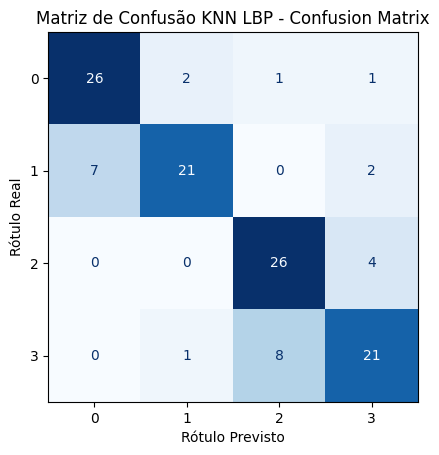

🎨 Gerando heatmaps de relevância para modelo: knn_lbp
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=nan, max=nan
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.027, max=0.260
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.245, max=1.000
Reconstructing

'results/csv_exports/knn_lbp_results.csv'

In [54]:
print("🚀 === CALCULANDO RELEVÂNCIA DOS MODELOS KNN ===")

class_names = image_categories
base_name = 'KNN'

print("\n📊 Calculando relevância LBP...")
relevance_results_knn_lbp = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_lbp_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, knn_lbp_max_relevances, _, _, _, (knn_lbp_true_y, knn_lbp_predicted_y), knn_lbp_relevance_metrics = relevance_results_knn_lbp

show_metrics(knn_lbp_relevance_metrics, title=f"{base_name} LBP")
show_confusion_matrix(knn_lbp_true_y, knn_lbp_predicted_y, title=f"{base_name} LBP - Confusion Matrix", cmap='Blues')
generate_relevance_heatmaps(
    max_relevances=knn_lbp_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_lbp,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP"
)


📊 Calculando relevância GLCM...
🚀 Iniciando treinamento de especialistas KNN-GLCM
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-GLCM-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-GLCM-Specialist-cats ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâm

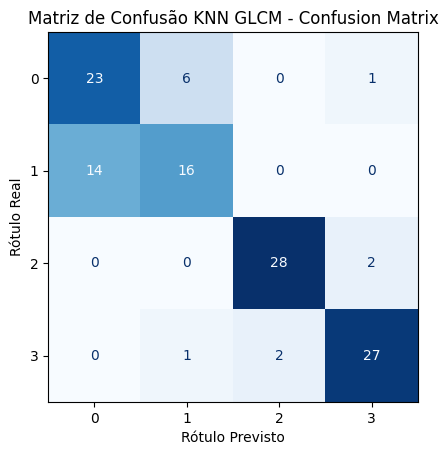

🎨 Gerando heatmaps de relevância para modelo: knn_glcm
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.042, max=0.619
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.012, max=0.604
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.127, max=1.000
Reconstru

'results/csv_exports/knn_glcm_results.csv'

In [55]:
# Treina especialistas para GLCM
print("\n📊 Calculando relevância GLCM...")
relevance_results_knn_glcm = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_glcm_max_relevances,
    _,
    _,
    _,
    (knn_glcm_true_y, knn_glcm_predicted_y),
    knn_glcm_relevance_metrics,
) = relevance_results_knn_glcm

show_metrics(knn_glcm_relevance_metrics, title="KNN GLCM")
show_confusion_matrix(
    knn_glcm_true_y,
    knn_glcm_predicted_y,
    title="KNN GLCM - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM"
)


📊 Calculando relevância LPQ...
🚀 Iniciando treinamento de especialistas KNN-LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------


Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-LPQ-Specialist-cats ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
----------------------------------------

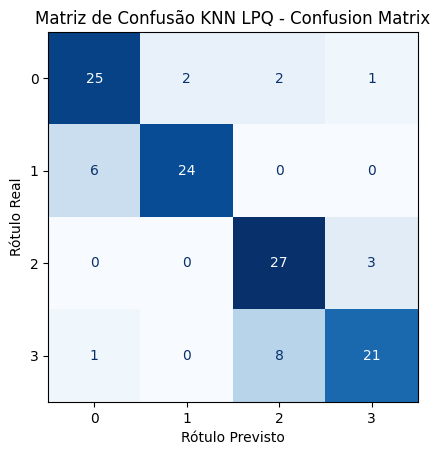

🎨 Gerando heatmaps de relevância para modelo: knn_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.029, max=1.000
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.012, max=0.315
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.029, max=1.000
Reconstruc

'results/csv_exports/knn_lpq_results.csv'

In [56]:
# Calcula relevância para LPQ
print("\n📊 Calculando relevância LPQ...")
relevance_results_knn_lpq = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_lpq_max_relevances,
    _,
    _,
    _,
    (knn_lpq_true_y, knn_lpq_predicted_y),
    knn_lpq_relevance_metrics,
) = relevance_results_knn_lpq

show_metrics(knn_lpq_relevance_metrics, title="KNN LPQ")
show_confusion_matrix(
    knn_lpq_true_y,
    knn_lpq_predicted_y,
    title="KNN LPQ - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LPQ"
)


📊 Calculando relevância LBP+GLCM...
🚀 Iniciando treinamento de especialistas KNN-LBP+GLCM
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-LBP+GLCM-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-LBP+GLCM-Specialist-cats ===
Validação cruzada: 5 folds
-------------------------------------------------

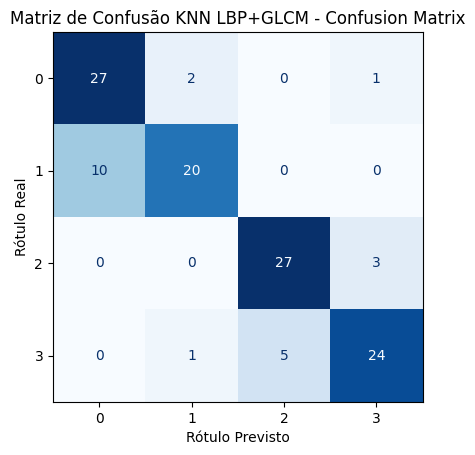

🎨 Gerando heatmaps de relevância para modelo: knn_lbp_glcm
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.077, max=1.000
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.008, max=0.298
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.124, max=1.000
Recon

'results/csv_exports/knn_lbp_glcm_results.csv'

In [57]:
# Calcula relevância para LBP+GLCM
print("\n📊 Calculando relevância LBP+GLCM...")
relevance_results_knn_lbp_glcm = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_lbp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_lbp_glcm_max_relevances,
    _,
    _,
    _,
    (knn_lbp_glcm_true_y, knn_lbp_glcm_predicted_y),
    knn_lbp_glcm_relevance_metrics,
) = relevance_results_knn_lbp_glcm

show_metrics(knn_lbp_glcm_relevance_metrics, title="KNN LBP+GLCM")
show_confusion_matrix(
    knn_lbp_glcm_true_y,
    knn_lbp_glcm_predicted_y,
    title="KNN LBP+GLCM - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_lbp_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_lbp_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM"
)


📊 Calculando relevância LBP+LPQ...
🚀 Iniciando treinamento de especialistas KNN-LBP+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-LBP+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-LBP+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
--------------------------------------------------
Me

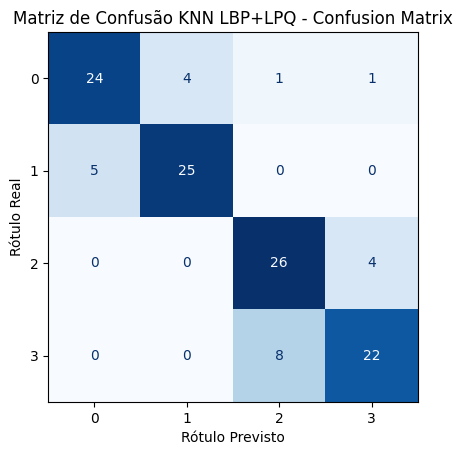

🎨 Gerando heatmaps de relevância para modelo: knn_lbp_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.043, max=1.000
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.026, max=0.309
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.123, max=1.000
Recons

'results/csv_exports/knn_lbp_lpq_results.csv'

In [58]:
# Calcula relevância para LBP+LPQ
print("\n📊 Calculando relevância LBP+LPQ...")
relevance_results_knn_lbp_lpq = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_lbp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_lbp_lpq_max_relevances,
    _,
    _,
    _,
    (knn_lbp_lpq_true_y, knn_lbp_lpq_predicted_y),
    knn_lbp_lpq_relevance_metrics,
) = relevance_results_knn_lbp_lpq

show_metrics(knn_lbp_lpq_relevance_metrics, title="KNN LBP+LPQ")
show_confusion_matrix(
    knn_lbp_lpq_true_y,
    knn_lbp_lpq_predicted_y,
    title="KNN LBP+LPQ - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_lbp_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_lbp_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_LPQ"
)


📊 Calculando relevância GLCM+LPQ...
🚀 Iniciando treinamento de especialistas KNN-GLCM+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-GLCM+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-GLCM+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
-------------------------------------------------

/home/afmireski/Documentos/BCC/TCC/tcc_image_classification_by_relevance_of_regions/tools/relevance.py:199: RuntimeWarning: invalid value encountered in divide
  norm_probs = probs / probs.sum(axis=1, keepdims=True)


💾 Matriz de confusão salva em: results/confusion_matrixs/knn_glcm_lpq___confusion_matrix_confusion_matrix.png


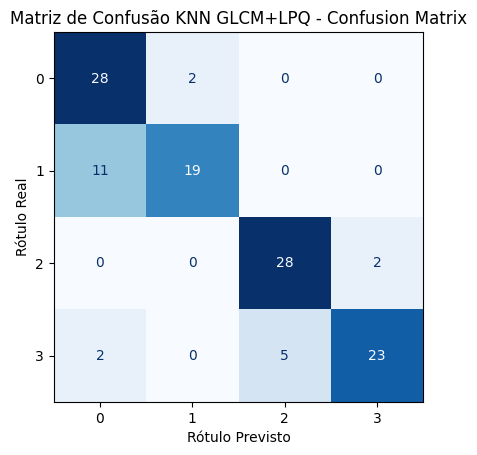

🎨 Gerando heatmaps de relevância para modelo: knn_glcm_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.078, max=1.000
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.067, max=0.435
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.304, max=1.000
Recon

'results/csv_exports/knn_glcm_lpq_results.csv'

In [59]:
# Calcula relevância para GLCM+LPQ
print("\n📊 Calculando relevância GLCM+LPQ...")
relevance_results_knn_glcm_lpq = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_glcm_lpq_max_relevances,
    _,
    _,
    _,
    (knn_glcm_lpq_true_y, knn_glcm_lpq_predicted_y),
    knn_glcm_lpq_relevance_metrics,
) = relevance_results_knn_glcm_lpq

show_metrics(knn_glcm_lpq_relevance_metrics, title="KNN GLCM+LPQ")
show_confusion_matrix(
    knn_glcm_lpq_true_y,
    knn_glcm_lpq_predicted_y,
    title="KNN GLCM+LPQ - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM_LPQ"
)


📊 Calculando relevância LBP+GLCM+LPQ...
🚀 Iniciando treinamento de especialistas KNN-LBP+GLCM+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: KNN-LBP+GLCM+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3}
Melhores parâmetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: KNN-LBP+GLCM+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
---------------------------------

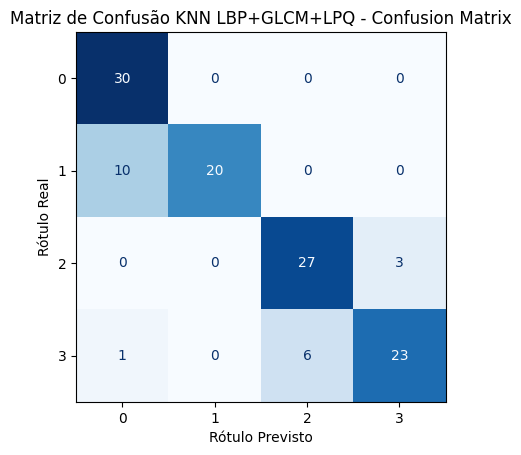

🎨 Gerando heatmaps de relevância para modelo: knn_lbp_glcm_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.023, max=0.503
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.007, max=0.318
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.118, max=1.000
R

'results/csv_exports/knn_lbp_glcm_lpq_results.csv'

In [60]:
# Calcula relevância para LBP+GLCM+LPQ
print("\n📊 Calculando relevância LBP+GLCM+LPQ...")
relevance_results_knn_lbp_glcm_lpq = relevance_technique(
    base_model=base_knn,
    specialist_sets=final_sp_lbp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels,
)

(
    _,
    _,
    _,
    knn_lbp_glcm_lpq_max_relevances,
    _,
    _,
    _,
    (knn_lbp_glcm_lpq_true_y, knn_lbp_glcm_lpq_predicted_y),
    knn_lbp_glcm_lpq_relevance_metrics,
) = relevance_results_knn_lbp_glcm_lpq

show_metrics(knn_lbp_glcm_lpq_relevance_metrics, title="KNN LBP+GLCM+LPQ")
show_confusion_matrix(
    knn_lbp_glcm_lpq_true_y,
    knn_lbp_glcm_lpq_predicted_y,
    title="KNN LBP+GLCM+LPQ - Confusion Matrix",
    cmap="Blues",
)
generate_relevance_heatmaps(
    max_relevances=knn_lbp_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_knn_lbp_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM_LPQ"
)

In [61]:
print("\n🎉 === CÁLCULO DE RELEVÂNCIA KNN CONCLUÍDO ===")
print("✅ Relevância calculada para todos os 7 conjuntos de features")
print("📊 Métricas e matrizes de confusão geradas para cada combinação")


🎉 === CÁLCULO DE RELEVÂNCIA KNN CONCLUÍDO ===
✅ Relevância calculada para todos os 7 conjuntos de features
📊 Métricas e matrizes de confusão geradas para cada combinação


## SVM

🚀 === CALCULANDO RELEVÂNCIA DOS MODELOS SVM ===

📊 Calculando relevância LBP...
🚀 Iniciando treinamento de especialistas SVM-LBP
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-LBP-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-LBP-Specialist-cats ===
Validação cr

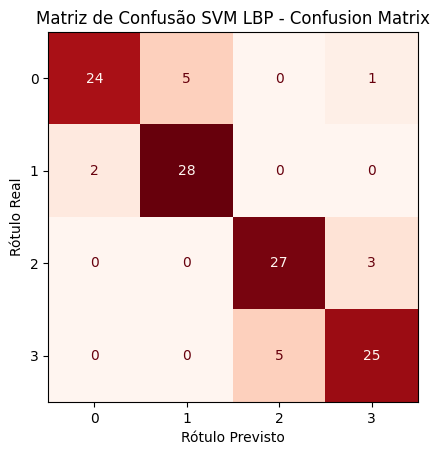

🎨 Gerando heatmaps de relevância para modelo: svm_lbp
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.006, max=0.506
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.080, max=0.406
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.023, max=0.695
Reconstruc

'results/csv_exports/svm_lbp_results.csv'

In [62]:
print("🚀 === CALCULANDO RELEVÂNCIA DOS MODELOS SVM ===")

class_names = image_categories
base_name = 'SVM'

print("\n📊 Calculando relevância LBP...")
relevance_results_svm_lbp = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_lbp_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_lbp_max_relevances, _, _, _, (svm_lbp_true_y, svm_lbp_predicted_y), svm_lbp_relevance_metrics = relevance_results_svm_lbp

show_metrics(svm_lbp_relevance_metrics, title="SVM LBP")
show_confusion_matrix(svm_lbp_true_y, svm_lbp_predicted_y, title="SVM LBP - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_lbp_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_lbp,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP"
)


📊 Calculando relevância GLCM...
🚀 Iniciando treinamento de especialistas SVM-GLCM
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-GLCM-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-GLCM-Specialist-cats ===
Validação cruzada: 5 folds
--------------------------

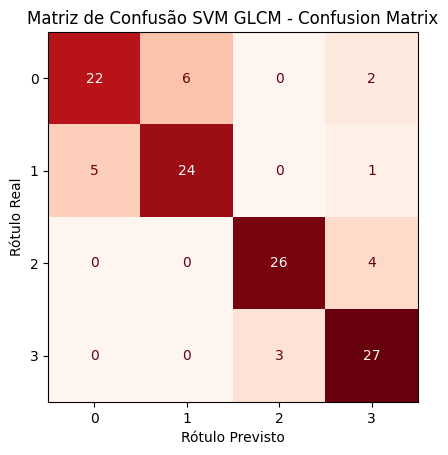

🎨 Gerando heatmaps de relevância para modelo: svm_glcm
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.045, max=0.617
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.054, max=0.630
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.093, max=0.271
Reconstru

'results/csv_exports/svm_glcm_results.csv'

In [63]:
print("\n📊 Calculando relevância GLCM...")
relevance_results_svm_glcm = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_glcm_max_relevances, _, _, _, (svm_glcm_true_y, svm_glcm_predicted_y), svm_glcm_relevance_metrics = relevance_results_svm_glcm

show_metrics(svm_glcm_relevance_metrics, title="SVM GLCM")
show_confusion_matrix(svm_glcm_true_y, svm_glcm_predicted_y, title="SVM GLCM - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM"
)


📊 Calculando relevância LPQ...
🚀 Iniciando treinamento de especialistas SVM-LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-LPQ-Specialist-cats ===
Validação cruzada: 5 folds
-------------------------------------

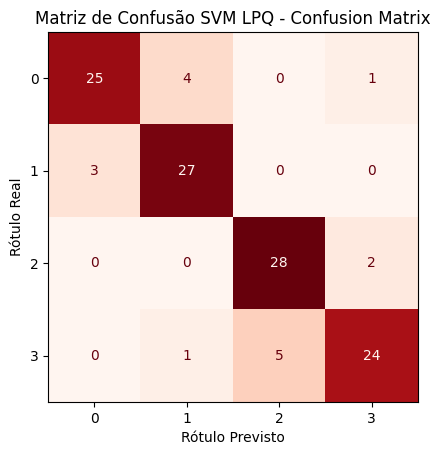

🎨 Gerando heatmaps de relevância para modelo: svm_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.011, max=0.721
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.031, max=0.432
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.060, max=0.846
Reconstruc

'results/csv_exports/svm_lpq_results.csv'

In [64]:
print("\n📊 Calculando relevância LPQ...")
relevance_results_svm_lpq = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_lpq_max_relevances, _, _, _, (svm_lpq_true_y, svm_lpq_predicted_y), svm_lpq_relevance_metrics = relevance_results_svm_lpq

show_metrics(svm_lpq_relevance_metrics, title="SVM LPQ")
show_confusion_matrix(svm_lpq_true_y, svm_lpq_predicted_y, title="SVM LPQ - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LPQ"
)


📊 Calculando relevância LBP+GLCM...
🚀 Iniciando treinamento de especialistas SVM-LBP+GLCM
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-LBP+GLCM-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-LBP+GLCM-Specialist-cats ===
Validação cruzada: 5 folds
--------------

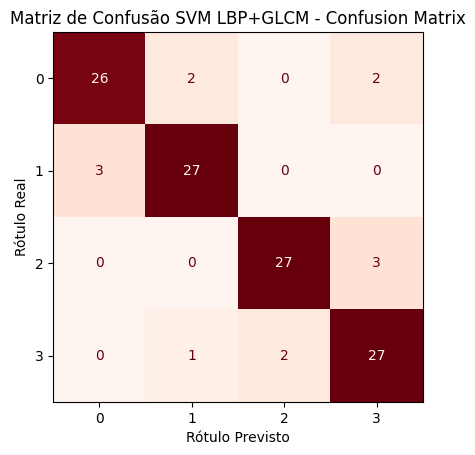

🎨 Gerando heatmaps de relevância para modelo: svm_lbp_glcm
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.128, max=0.506
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.132, max=0.445
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.112, max=0.705
Recon

'results/csv_exports/svm_lbp_glcm_results.csv'

In [65]:
print("\n📊 Calculando relevância LBP+GLCM...")
relevance_results_svm_lbp_glcm = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_lbp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_lbp_glcm_max_relevances, _, _, _, (svm_lbp_glcm_true_y, svm_lbp_glcm_predicted_y), svm_lbp_glcm_relevance_metrics = relevance_results_svm_lbp_glcm

show_metrics(svm_lbp_glcm_relevance_metrics, title="SVM LBP+GLCM")
show_confusion_matrix(svm_lbp_glcm_true_y, svm_lbp_glcm_predicted_y, title="SVM LBP+GLCM - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_lbp_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_lbp_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM"
)


📊 Calculando relevância LBP+LPQ...
🚀 Iniciando treinamento de especialistas SVM-LBP+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-LBP+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-LBP+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
------------------

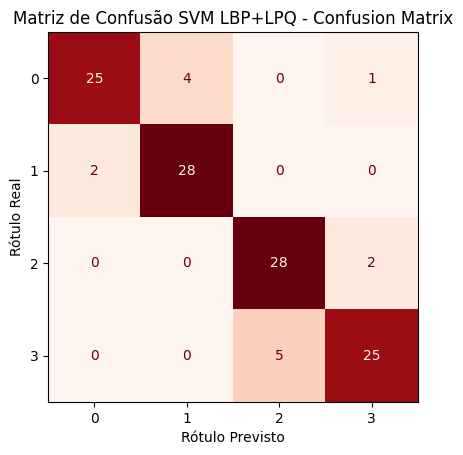

🎨 Gerando heatmaps de relevância para modelo: svm_lbp_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.016, max=0.570
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.081, max=0.325
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.051, max=0.806
Recons

'results/csv_exports/svm_lbp_lpq_results.csv'

In [66]:
print("\n📊 Calculando relevância LBP+LPQ...")
relevance_results_svm_lbp_lpq = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_lbp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_lbp_lpq_max_relevances, _, _, _, (svm_lbp_lpq_true_y, svm_lbp_lpq_predicted_y), svm_lbp_lpq_relevance_metrics = relevance_results_svm_lbp_lpq

show_metrics(svm_lbp_lpq_relevance_metrics, title="SVM LBP+LPQ")
show_confusion_matrix(svm_lbp_lpq_true_y, svm_lbp_lpq_predicted_y, title="SVM LBP+LPQ - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_lbp_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_lbp_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_LPQ"
)


📊 Calculando relevância GLCM+LPQ...
🚀 Iniciando treinamento de especialistas SVM-GLCM+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-GLCM+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 2e-05, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-GLCM+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
-------------

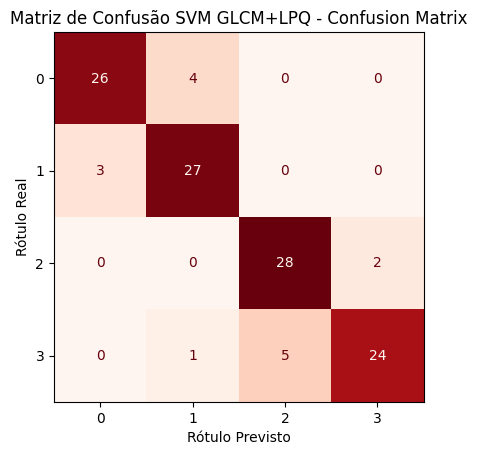

🎨 Gerando heatmaps de relevância para modelo: svm_glcm_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.124, max=0.715
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.075, max=0.437
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.044, max=0.822
Recon

'results/csv_exports/svm_glcm_lpq_results.csv'

In [67]:
print("\n📊 Calculando relevância GLCM+LPQ...")
relevance_results_svm_glcm_lpq = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_glcm_lpq_max_relevances, _, _, _, (svm_glcm_lpq_true_y, svm_glcm_lpq_predicted_y), svm_glcm_lpq_relevance_metrics = relevance_results_svm_glcm_lpq

show_metrics(svm_glcm_lpq_relevance_metrics, title="SVM GLCM+LPQ")
show_confusion_matrix(svm_glcm_lpq_true_y, svm_glcm_lpq_predicted_y, title="SVM GLCM+LPQ - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM_LPQ"
)


📊 Calculando relevância LBP+GLCM+LPQ...
🚀 Iniciando treinamento de especialistas SVM-LBP+GLCM+LPQ
   📋 4 especialistas para treinar
   🔄 Validação cruzada: 5 folds
------------------------------------------------------------

🎯 Treinando especialista 1/4: dogs
=== Iniciando treinamento assistido: SVM-LBP+GLCM+LPQ-Specialist-dogs ===
Validação cruzada: 5 folds
--------------------------------------------------


Melhores parâmetros: {'svm__C': 1000, 'svm__gamma': 2e-05, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
--------------------------------------------------

🎯 Treinando especialista 2/4: cats
=== Iniciando treinamento assistido: SVM-LBP+GLCM+LPQ-Specialist-cats ===
Validação cruzada: 5 folds
--------------------------------------------------
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.002, 'svm__kernel': 'rbf'}
Melhores parâmetros: {'svm__C': 100, 's

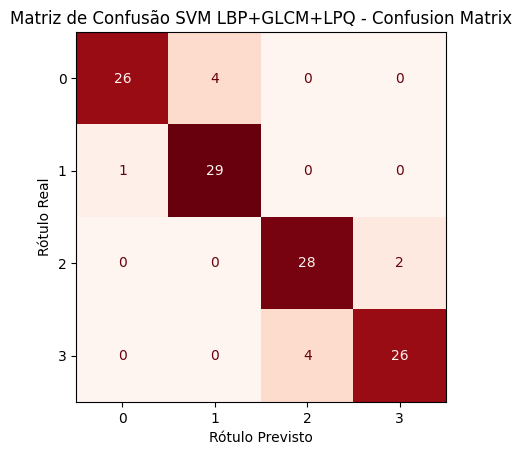

🎨 Gerando heatmaps de relevância para modelo: svm_lbp_glcm_lpq
   📊 Colormap: rainbow
   🎭 Transparência overlay: 0.5
   🔲 Linhas de grade: True
------------------------------------------------------------
   ✅ 120 imagens serão processadas
   🔄 Processando cat1: grade 3x3 = 9 segmentos
       Relevâncias: min=0.219, max=0.755
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat10: grade 3x3 = 9 segmentos
       Relevâncias: min=0.004, max=0.444
Reconstructing image from regions...
       🔲 Linhas de grade adicionadas
Reconstructing image from regions...
       💾 Salvo com sucesso
       🎨 Heatmap final: (512, 512, 3) (altura, largura, RGB)
       🎭 Overlay criado com transparência: 0.5
   🔄 Processando cat11: grade 3x3 = 9 segmentos
       Relevâncias: min=0.035, max=0.742
R

'results/csv_exports/svm_lbp_glcm_lpq_results.csv'

In [68]:
print("\n📊 Calculando relevância LBP+GLCM+LPQ...")
relevance_results_svm_lbp_glcm_lpq = relevance_technique(
    base_model=base_svm,
    specialist_sets=final_sp_lbp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, svm_lbp_glcm_lpq_max_relevances, _, _, _, (svm_lbp_glcm_lpq_true_y, svm_lbp_glcm_lpq_predicted_y), svm_lbp_glcm_lpq_relevance_metrics = relevance_results_svm_lbp_glcm_lpq

show_metrics(svm_lbp_glcm_lpq_relevance_metrics, title="SVM LBP+GLCM+LPQ")
show_confusion_matrix(svm_lbp_glcm_lpq_true_y, svm_lbp_glcm_lpq_predicted_y, title="SVM LBP+GLCM+LPQ - Confusion Matrix", cmap='Reds')
generate_relevance_heatmaps(
    max_relevances=svm_lbp_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_svm_lbp_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM_LPQ"
)

In [69]:
print("✅ Relevância calculada para todos os 7 conjuntos de features")
print("📊 Métricas e matrizes de confusão geradas para cada combinação")
print("\n🎉 === CÁLCULO DE RELEVÂNCIA SVM CONCLUÍDO ===")

✅ Relevância calculada para todos os 7 conjuntos de features
📊 Métricas e matrizes de confusão geradas para cada combinação

🎉 === CÁLCULO DE RELEVÂNCIA SVM CONCLUÍDO ===


## Random Forest

In [ ]:
print("🚀 === CALCULANDO RELEVÂNCIA DOS MODELOS RF ===")

class_names = image_categories
base_name = 'RF'

print("\n📊 Calculando relevância LBP...")
relevance_results_rf_lbp = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_lbp_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_lbp_max_relevances, _, _, _, (rf_lbp_true_y, rf_lbp_predicted_y), rf_lbp_relevance_metrics = relevance_results_rf_lbp

show_metrics(rf_lbp_relevance_metrics, title=f"{base_name} LBP")
show_confusion_matrix(rf_lbp_true_y, rf_lbp_predicted_y, title=f"{base_name} LBP - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_lbp_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_lbp,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP"
)

In [ ]:
print("\n📊 Calculando relevância GLCM...")
relevance_results_rf_glcm = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_glcm_max_relevances, _, _, _, (rf_glcm_true_y, rf_glcm_predicted_y), rf_glcm_relevance_metrics = relevance_results_rf_glcm

show_metrics(rf_glcm_relevance_metrics, title=f"{base_name} GLCM")
show_confusion_matrix(rf_glcm_true_y, rf_glcm_predicted_y, title=f"{base_name} GLCM - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM"
)

In [ ]:
print("\n📊 Calculando relevância LPQ...")
relevance_results_rf_lpq = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_lpq_max_relevances, _, _, _, (rf_lpq_true_y, rf_lpq_predicted_y), rf_lpq_relevance_metrics = relevance_results_rf_lpq

show_metrics(rf_lpq_relevance_metrics, title=f"{base_name} LPQ")
show_confusion_matrix(rf_lpq_true_y, rf_lpq_predicted_y, title=f"{base_name} LPQ - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LPQ"
)

In [ ]:
print("\n📊 Calculando relevância LBP+GLCM...")
relevance_results_rf_lbp_glcm = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_lbp_glcm_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_lbp_glcm_max_relevances, _, _, _, (rf_lbp_glcm_true_y, rf_lbp_glcm_predicted_y), rf_lbp_glcm_relevance_metrics = relevance_results_rf_lbp_glcm

show_metrics(rf_lbp_glcm_relevance_metrics, title=f"{base_name} LBP+GLCM")
show_confusion_matrix(rf_lbp_glcm_true_y, rf_lbp_glcm_predicted_y, title=f"{base_name} LBP+GLCM - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_lbp_glcm_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_lbp_glcm,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM"
)

In [ ]:
print("\n📊 Calculando relevância LBP+LPQ...")
relevance_results_rf_lbp_lpq = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_lbp_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_lbp_lpq_max_relevances, _, _, _, (rf_lbp_lpq_true_y, rf_lbp_lpq_predicted_y), rf_lbp_lpq_relevance_metrics = relevance_results_rf_lbp_lpq

show_metrics(rf_lbp_lpq_relevance_metrics, title=f"{base_name} LBP+LPQ")
show_confusion_matrix(rf_lbp_lpq_true_y, rf_lbp_lpq_predicted_y, title=f"{base_name} LBP+LPQ - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_lbp_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_lbp_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_LPQ"
)

In [ ]:
print("\n📊 Calculando relevância GLCM+LPQ...")
relevance_results_rf_glcm_lpq = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_glcm_lpq_max_relevances, _, _, _, (rf_glcm_lpq_true_y, rf_glcm_lpq_predicted_y), rf_glcm_lpq_relevance_metrics = relevance_results_rf_glcm_lpq

show_metrics(rf_glcm_lpq_relevance_metrics, title=f"{base_name} GLCM+LPQ")
show_confusion_matrix(rf_glcm_lpq_true_y, rf_glcm_lpq_predicted_y, title=f"{base_name} GLCM+LPQ - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_GLCM_LPQ"
)

In [ ]:
print("\n📊 Calculando relevância LBP+GLCM+LPQ...")
relevance_results_rf_lbp_glcm_lpq = relevance_technique(
    base_model=base_rf,
    specialist_sets=final_sp_lbp_glcm_lpq_sets,
    class_names=class_names,
    model_name=f"{base_name}-LBP+GLCM+LPQ",
    k_folds=K_FOLDS,
    true_labels=true_images_labels
)

_, _, _, rf_lbp_glcm_lpq_max_relevances, _, _, _, (rf_lbp_glcm_lpq_true_y, rf_lbp_glcm_lpq_predicted_y), rf_lbp_glcm_lpq_relevance_metrics = relevance_results_rf_lbp_glcm_lpq

show_metrics(rf_lbp_glcm_lpq_relevance_metrics, title=f"{base_name} LBP+GLCM+LPQ")
show_confusion_matrix(rf_lbp_glcm_lpq_true_y, rf_lbp_glcm_lpq_predicted_y, title=f"{base_name} LBP+GLCM+LPQ - Confusion Matrix", cmap='Greens')
generate_relevance_heatmaps(
    max_relevances=rf_lbp_glcm_lpq_max_relevances,
    all_images_segmented=all_images_segmented,
    model_name=f"{base_name.lower()}_lbp_glcm_lpq",
    overlay_alpha=0.5,
    save_grid_lines=True,
    colormap='rainbow'
)

# Exporta resultados para CSV
export_relevance_results_to_csv(
    relevance_results=relevance_results_rf_lbp_glcm_lpq,
    true_labels=true_images_labels,
    model_name=f"{base_name}_LBP_GLCM_LPQ"
)

In [ ]:
print("✅ Relevância calculada para todos os 7 conjuntos de features")
print("📊 Métricas e matrizes de confusão geradas para cada combinação")
print("\n🎉 === CÁLCULO DE RELEVÂNCIA RF CONCLUÍDO ===")